# Model Evaluation: Counting the 'r's in "strawberry"

This notebook demonstrates how to use Kamiwaza SDK to evaluate multiple language models on a simple counting task. We'll deploy three different models, ask each one to count the number of 'r's in the word "strawberry" (the correct answer is 3), and compare their responses.

This approach shows how Kamiwaza can be used for automated model evaluation and benchmarking.

## 1. Setup

First, we'll initialize the Kamiwaza client and define the list of models we want to evaluate. We'll also create a directory to store our evaluation results.

In [18]:
from kamiwaza_sdk import kamiwaza_sdk as kz
import os
import json
from datetime import datetime

In [19]:
# Initialize the Kamiwaza client
client = kz("http://localhost:7777/api/")

# Define the models to evaluate
models = [
    "Qwen/Qwen2.5-Coder-0.5B-Instruct-GGUF",
    "Qwen/Qwen2.5-7B-Instruct-GGUF",
    "bartowski/Llama-3-8B-Instruct-Coder-v2-GGUF"
]

os.makedirs("eval_results", exist_ok=True)

## 2. Run Evaluations

Next, we'll loop through each model and:
1. Download and deploy the model (if not already downloaded)
2. Wait for the model to fully initialize
3. Run 50 evaluation queries asking "How many r's are in the word 'strawberry'?"
4. Save the results to a JSON file
5. Stop the deployment before moving to the next model

This automated process allows us to systematically test each model with the same prompt and collect their responses for comparison.

In [20]:
import time
from datetime import datetime
import json
import os

# Create output directory for results
os.makedirs("eval_results", exist_ok=True)

# Number of evaluation runs per model
num_runs = 500

# Evaluation prompt
prompt = "How many r's are in the word 'strawberry'? ONLY RESPOND WITH A SINGLE NUMBER"

# Track overall results
all_results = {}

for model_repo in models:
    print(f"Evaluating model: {model_repo}")
    model_name = model_repo.split('/')[-1]
    
    # Download and deploy the model
    print(f"Downloading and deploying {model_name}...")
    result = client.models.download_and_deploy_model(model_repo)
    deployment_id = result.get('deployment_id')
    
    if not deployment_id:
        print(f"Failed to deploy {model_name}, skipping...")
        continue
    
    # Fixed wait time to ensure model is fully loaded
    wait_time = 15  # seconds
    print(f"Waiting {wait_time} seconds for model to fully initialize...")
    time.sleep(wait_time)
    
    # Create OpenAI client for the model
    openai_client = client.openai.get_client(repo_id=model_repo)
    
    # Run evaluations and collect responses
    model_results = []
    print(f"Running {num_runs} evaluations...")
    
    for i in range(num_runs):
        try:
            start_time = time.time()
            response = openai_client.chat.completions.create(
                messages=[
                    {"role": "user", "content": prompt}
                ],
                model="model",
            )
            end_time = time.time()
            
            result = {
                "run_id": i,
                "response": response.choices[0].message.content.strip(),
                "time_seconds": end_time - start_time
            }
            model_results.append(result)
            
            print(f"Run {i+1}/{num_runs}: Response = '{result['response']}' ({result['time_seconds']:.2f}s)")
        except Exception as e:
            print(f"Error on run {i+1}: {str(e)}")
            result = {
                "run_id": i,
                "response": "ERROR",
                "time_seconds": time.time() - start_time,
                "error": str(e)
            }
            model_results.append(result)
    
    # Save the results to a file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"eval_results/{model_name}_{timestamp}.json"
    
    with open(filename, "w") as f:
        json.dump(model_results, f, indent=2)
    
    print(f"Results saved to {filename}")
    all_results[model_name] = {
        "filename": filename,
        "results": model_results
    }
    
    # Stop the deployment
    print(f"Stopping deployment for {model_name}...")
    client.serving.stop_deployment(repo_id=model_repo)

# Save the overall results
with open("eval_results/all_models_summary.json", "w") as f:
    # We'll save just the filenames in the summary to avoid duplicating all the data
    summary = {k: {"filename": v["filename"]} for k, v in all_results.items()}
    json.dump(summary, f, indent=2)

print("All evaluations complete!")

Evaluating model: Qwen/Qwen2.5-Coder-0.5B-Instruct-GGUF
Initiating download for Qwen/Qwen2.5-Coder-0.5B-Instruct-GGUF with quantization q6_k...
Waiting for download to complete...
Overall: 0.0% [00:00] | Active: 0, Completed: 0, Total: 1                       
Download complete for: Qwen/Qwen2.5-Coder-0.5B-Instruct-GGUF
Total download time: 00:00
Files downloaded:
- qwen2.5-coder-0.5b-instruct-q6_k.gguf (620.25 MB)
Model ID: d67d5808-f95b-466f-9f85-09e1354553d7
Deploying model Qwen/Qwen2.5-Coder-0.5B-Instruct-GGUF...
Model Qwen/Qwen2.5-Coder-0.5B-Instruct-GGUF successfully deployed!
Waiting 15 seconds for model to fully initialize...


2025-03-07 14:19:10,944 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:10,968 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:10,988 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,008 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Running 500 evaluations...
Run 1/500: Response = '1' (0.06s)
Run 2/500: Response = '6' (0.02s)
Run 3/500: Response = '1' (0.02s)
Run 4/500: Response = '1' (0.02s)


2025-03-07 14:19:11,091 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,110 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,131 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,153 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,172 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,191 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,210 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,230 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,249 - httpx 

Run 5/500: Response = '1' (0.08s)
Run 6/500: Response = '4' (0.02s)
Run 7/500: Response = '3' (0.02s)
Run 8/500: Response = '4' (0.02s)
Run 9/500: Response = '4' (0.02s)
Run 10/500: Response = '4' (0.02s)
Run 11/500: Response = '3' (0.02s)
Run 12/500: Response = '3' (0.02s)
Run 13/500: Response = '5' (0.02s)
Run 14/500: Response = '4' (0.02s)
Run 15/500: Response = '1' (0.02s)


2025-03-07 14:19:11,305 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,325 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,347 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,367 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,391 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,413 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,432 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,454 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,476 - httpx 

Run 16/500: Response = '1' (0.02s)
Run 17/500: Response = '2' (0.02s)
Run 18/500: Response = '1' (0.02s)
Run 19/500: Response = '3' (0.02s)
Run 20/500: Response = '3' (0.02s)
Run 21/500: Response = '4' (0.02s)
Run 22/500: Response = '1' (0.02s)
Run 23/500: Response = '3' (0.02s)
Run 24/500: Response = '6' (0.02s)
Run 25/500: Response = '4' (0.02s)


2025-03-07 14:19:11,517 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,541 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,563 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,584 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,605 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,629 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,651 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,670 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,690 - httpx 

Run 26/500: Response = '5' (0.02s)
Run 27/500: Response = '5' (0.02s)
Run 28/500: Response = '3' (0.02s)
Run 29/500: Response = '2' (0.02s)
Run 30/500: Response = '1' (0.02s)
Run 31/500: Response = '1' (0.02s)
Run 32/500: Response = '1' (0.02s)
Run 33/500: Response = '2' (0.02s)
Run 34/500: Response = '3' (0.02s)
Run 35/500: Response = '1' (0.02s)


2025-03-07 14:19:11,736 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,756 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,776 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,802 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,823 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,843 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,866 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,885 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,915 - httpx 

Run 36/500: Response = '5' (0.02s)
Run 37/500: Response = '3' (0.02s)
Run 38/500: Response = '2' (0.02s)
Run 39/500: Response = '3' (0.03s)
Run 40/500: Response = '3' (0.02s)
Run 41/500: Response = '2' (0.02s)
Run 42/500: Response = '2' (0.02s)
Run 43/500: Response = '3' (0.02s)
Run 44/500: Response = '1' (0.03s)
Run 45/500: Response = '1' (0.02s)


2025-03-07 14:19:11,961 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:11,983 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,003 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,022 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,042 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,060 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,081 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,101 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,121 - httpx 

Run 46/500: Response = '3' (0.03s)
Run 47/500: Response = '1' (0.02s)
Run 48/500: Response = '6' (0.02s)
Run 49/500: Response = '3' (0.02s)
Run 50/500: Response = '4' (0.02s)
Run 51/500: Response = '1' (0.02s)
Run 52/500: Response = '1' (0.02s)
Run 53/500: Response = '4' (0.02s)
Run 54/500: Response = '2' (0.02s)
Run 55/500: Response = '5' (0.02s)


2025-03-07 14:19:12,166 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,185 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,206 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,225 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,247 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,268 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,290 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,312 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,336 - httpx 

Run 56/500: Response = '3' (0.02s)
Run 57/500: Response = '5' (0.02s)
Run 58/500: Response = '2' (0.02s)
Run 59/500: Response = '2' (0.02s)
Run 60/500: Response = '1' (0.02s)
Run 61/500: Response = '1' (0.02s)
Run 62/500: Response = '2' (0.02s)
Run 63/500: Response = '2' (0.02s)
Run 64/500: Response = '3' (0.02s)
Run 65/500: Response = '2' (0.03s)


2025-03-07 14:19:12,386 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,411 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,442 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,473 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,504 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,534 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,565 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 66/500: Response = '2' (0.02s)
Run 67/500: Response = '2' (0.02s)
Run 68/500: Response = '3' (0.03s)
Run 69/500: Response = '3' (0.03s)
Run 70/500: Response = '1' (0.03s)
Run 71/500: Response = '3' (0.03s)
Run 72/500: Response = '3' (0.03s)


2025-03-07 14:19:12,591 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,614 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,636 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,663 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,685 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,706 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,730 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,754 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,781 - httpx 

Run 73/500: Response = '5' (0.03s)
Run 74/500: Response = '1' (0.02s)
Run 75/500: Response = '1' (0.02s)
Run 76/500: Response = '6' (0.03s)
Run 77/500: Response = '3' (0.02s)
Run 78/500: Response = '2' (0.02s)
Run 79/500: Response = '1' (0.02s)
Run 80/500: Response = '2' (0.03s)
Run 81/500: Response = '5' (0.03s)


2025-03-07 14:19:12,807 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,834 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,860 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,882 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,904 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,925 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,950 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,970 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:12,992 - httpx 

Run 82/500: Response = '6' (0.03s)
Run 83/500: Response = '3' (0.03s)
Run 84/500: Response = '4' (0.03s)
Run 85/500: Response = '3' (0.02s)
Run 86/500: Response = '2' (0.02s)
Run 87/500: Response = '3' (0.02s)
Run 88/500: Response = '1' (0.02s)
Run 89/500: Response = '1' (0.02s)
Run 90/500: Response = '1' (0.02s)


2025-03-07 14:19:13,013 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,046 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,065 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,085 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,105 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,127 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,163 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,185 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,205 - httpx 

Run 91/500: Response = '1' (0.02s)
Run 92/500: Response = '4' (0.03s)
Run 93/500: Response = '6' (0.02s)
Run 94/500: Response = '2' (0.02s)
Run 95/500: Response = '2' (0.02s)
Run 96/500: Response = '1' (0.02s)
Run 97/500: Response = '2' (0.04s)
Run 98/500: Response = '2' (0.02s)
Run 99/500: Response = '3' (0.02s)


2025-03-07 14:19:13,226 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,247 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,267 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,287 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,308 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,330 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,350 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,370 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,392 - httpx 

Run 100/500: Response = '3' (0.02s)
Run 101/500: Response = '2' (0.02s)
Run 102/500: Response = '2' (0.02s)
Run 103/500: Response = '1' (0.02s)
Run 104/500: Response = '3' (0.02s)
Run 105/500: Response = '3' (0.02s)
Run 106/500: Response = '1' (0.02s)
Run 107/500: Response = '5' (0.02s)
Run 108/500: Response = '3' (0.02s)
Run 109/500: Response = '3' (0.02s)


2025-03-07 14:19:13,431 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,450 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,473 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,495 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,515 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,534 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,556 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,579 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,601 - httpx 

Run 110/500: Response = '4' (0.02s)
Run 111/500: Response = '1' (0.02s)
Run 112/500: Response = '2' (0.02s)
Run 113/500: Response = '3' (0.02s)
Run 114/500: Response = '2' (0.02s)
Run 115/500: Response = '4' (0.02s)
Run 116/500: Response = '1' (0.02s)
Run 117/500: Response = '1' (0.02s)
Run 118/500: Response = '3' (0.02s)
Run 119/500: Response = '3' (0.03s)


2025-03-07 14:19:13,651 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,675 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,699 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,722 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,748 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,774 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,802 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,830 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 120/500: Response = '2' (0.02s)
Run 121/500: Response = '5' (0.02s)
Run 122/500: Response = '1' (0.02s)
Run 123/500: Response = '3' (0.02s)
Run 124/500: Response = '4' (0.03s)
Run 125/500: Response = '2' (0.03s)
Run 126/500: Response = '2' (0.03s)
Run 127/500: Response = '3' (0.03s)


2025-03-07 14:19:13,864 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,891 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,918 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,940 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,963 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:13,983 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,005 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,030 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,057 - httpx 

Run 128/500: Response = '1' (0.03s)
Run 129/500: Response = '3' (0.03s)
Run 130/500: Response = '2' (0.03s)
Run 131/500: Response = '1' (0.02s)
Run 132/500: Response = '2' (0.02s)
Run 133/500: Response = '1' (0.02s)
Run 134/500: Response = '1' (0.02s)
Run 135/500: Response = '2' (0.02s)
Run 136/500: Response = '2' (0.03s)


2025-03-07 14:19:14,082 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,105 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,128 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,150 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,170 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,190 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,211 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,240 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,261 - httpx 

Run 137/500: Response = '3' (0.02s)
Run 138/500: Response = '2' (0.02s)
Run 139/500: Response = '2' (0.02s)
Run 140/500: Response = '1' (0.02s)
Run 141/500: Response = '4' (0.02s)
Run 142/500: Response = '2' (0.02s)
Run 143/500: Response = '1' (0.02s)
Run 144/500: Response = '3' (0.03s)
Run 145/500: Response = '1' (0.02s)
Run 146/500: Response = '4' (0.02s)


2025-03-07 14:19:14,300 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,321 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,347 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,366 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,385 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,405 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,426 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,447 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,479 - httpx 

Run 147/500: Response = '3' (0.02s)
Run 148/500: Response = '2' (0.02s)
Run 149/500: Response = '4' (0.03s)
Run 150/500: Response = '3' (0.02s)
Run 151/500: Response = '1' (0.02s)
Run 152/500: Response = '2' (0.02s)
Run 153/500: Response = '3' (0.02s)
Run 154/500: Response = '1' (0.02s)
Run 155/500: Response = '1' (0.03s)
Run 156/500: Response = '2' (0.02s)


2025-03-07 14:19:14,518 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,538 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,558 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,583 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,604 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,625 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,645 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,669 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,690 - httpx 

Run 157/500: Response = '3' (0.02s)
Run 158/500: Response = '2' (0.02s)
Run 159/500: Response = '3' (0.02s)
Run 160/500: Response = '2' (0.02s)
Run 161/500: Response = '3' (0.02s)
Run 162/500: Response = '3' (0.02s)
Run 163/500: Response = '2' (0.02s)
Run 164/500: Response = '6' (0.02s)
Run 165/500: Response = '1' (0.02s)
Run 166/500: Response = '1' (0.02s)


2025-03-07 14:19:14,731 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,753 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,773 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,794 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,817 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,838 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,858 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,880 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,900 - httpx 

Run 167/500: Response = '4' (0.02s)
Run 168/500: Response = '5' (0.02s)
Run 169/500: Response = '6' (0.02s)
Run 170/500: Response = '1' (0.02s)
Run 171/500: Response = '1' (0.02s)
Run 172/500: Response = '3' (0.02s)
Run 173/500: Response = '1' (0.02s)
Run 174/500: Response = '4' (0.02s)
Run 175/500: Response = '1' (0.02s)
Run 176/500: Response = '4' (0.02s)


2025-03-07 14:19:14,943 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,963 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:14,986 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,009 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,030 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,051 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,077 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,104 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,125 - httpx 

Run 177/500: Response = '2' (0.02s)
Run 178/500: Response = '3' (0.02s)
Run 179/500: Response = '4' (0.02s)
Run 180/500: Response = '5' (0.02s)
Run 181/500: Response = '3' (0.02s)
Run 182/500: Response = '3' (0.02s)
Run 183/500: Response = '3' (0.03s)
Run 184/500: Response = '4' (0.03s)
Run 185/500: Response = '1' (0.02s)
Run 186/500: Response = '1' (0.02s)


2025-03-07 14:19:15,163 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,183 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,209 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,228 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,249 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,269 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,289 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,316 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,337 - httpx 

Run 187/500: Response = '2' (0.02s)
Run 188/500: Response = '1' (0.02s)
Run 189/500: Response = '2' (0.03s)
Run 190/500: Response = '1' (0.02s)
Run 191/500: Response = '2' (0.02s)
Run 192/500: Response = '1' (0.02s)
Run 193/500: Response = '4' (0.02s)
Run 194/500: Response = '4' (0.03s)
Run 195/500: Response = '3' (0.02s)
Run 196/500: Response = '1' (0.02s)


2025-03-07 14:19:15,381 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,400 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,419 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,441 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,463 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,489 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,508 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,534 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,552 - httpx 

Run 197/500: Response = '5' (0.02s)
Run 198/500: Response = '5' (0.02s)
Run 199/500: Response = '2' (0.02s)
Run 200/500: Response = '3' (0.02s)
Run 201/500: Response = '4' (0.02s)
Run 202/500: Response = '4' (0.03s)
Run 203/500: Response = '1' (0.02s)
Run 204/500: Response = '2' (0.03s)
Run 205/500: Response = '1' (0.02s)
Run 206/500: Response = '3' (0.02s)


2025-03-07 14:19:15,591 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,612 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,646 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,665 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,688 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,710 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,732 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,755 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,779 - httpx 

Run 207/500: Response = '1' (0.02s)
Run 208/500: Response = '1' (0.02s)
Run 209/500: Response = '2' (0.03s)
Run 210/500: Response = '2' (0.02s)
Run 211/500: Response = '1' (0.02s)
Run 212/500: Response = '1' (0.02s)
Run 213/500: Response = '3' (0.02s)
Run 214/500: Response = '3' (0.02s)
Run 215/500: Response = '1' (0.02s)


2025-03-07 14:19:15,803 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,827 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,852 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,877 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,901 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,922 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,944 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,966 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:15,991 - httpx 

Run 216/500: Response = '2' (0.02s)
Run 217/500: Response = '3' (0.02s)
Run 218/500: Response = '2' (0.03s)
Run 219/500: Response = '3' (0.03s)
Run 220/500: Response = '3' (0.02s)
Run 221/500: Response = '2' (0.02s)
Run 222/500: Response = '3' (0.02s)
Run 223/500: Response = '2' (0.02s)
Run 224/500: Response = '1' (0.03s)


2025-03-07 14:19:16,010 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,028 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,047 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,072 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,091 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,114 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,140 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,160 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,182 - httpx 

Run 225/500: Response = '1' (0.02s)
Run 226/500: Response = '2' (0.02s)
Run 227/500: Response = '1' (0.02s)
Run 228/500: Response = '3' (0.03s)
Run 229/500: Response = '1' (0.02s)
Run 230/500: Response = '3' (0.02s)
Run 231/500: Response = '6' (0.03s)
Run 232/500: Response = '3' (0.02s)
Run 233/500: Response = '2' (0.02s)
Run 234/500: Response = '1' (0.02s)


2025-03-07 14:19:16,219 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,240 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,265 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,284 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,302 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,322 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,340 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,359 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,393 - httpx 

Run 235/500: Response = '3' (0.02s)
Run 236/500: Response = '1' (0.02s)
Run 237/500: Response = '1' (0.02s)
Run 238/500: Response = '4' (0.02s)
Run 239/500: Response = '1' (0.02s)
Run 240/500: Response = '2' (0.02s)
Run 241/500: Response = '3' (0.02s)
Run 242/500: Response = '2' (0.02s)
Run 243/500: Response = '4' (0.03s)
Run 244/500: Response = '3' (0.02s)


2025-03-07 14:19:16,433 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,453 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,472 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,505 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,524 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,543 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,564 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,585 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,605 - httpx 

Run 245/500: Response = '3' (0.02s)
Run 246/500: Response = '4' (0.02s)
Run 247/500: Response = '1' (0.02s)
Run 248/500: Response = '3' (0.03s)
Run 249/500: Response = '2' (0.02s)
Run 250/500: Response = '3' (0.02s)
Run 251/500: Response = '3' (0.02s)
Run 252/500: Response = '1' (0.02s)
Run 253/500: Response = '5' (0.02s)
Run 254/500: Response = '2' (0.02s)


2025-03-07 14:19:16,647 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,668 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,688 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,708 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,742 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,765 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,785 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,806 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,827 - httpx 

Run 255/500: Response = '3' (0.02s)
Run 256/500: Response = '2' (0.02s)
Run 257/500: Response = '2' (0.02s)
Run 258/500: Response = '2' (0.02s)
Run 259/500: Response = '2' (0.03s)
Run 260/500: Response = '2' (0.02s)
Run 261/500: Response = '1' (0.02s)
Run 262/500: Response = '2' (0.02s)
Run 263/500: Response = '1' (0.02s)


2025-03-07 14:19:16,859 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,881 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,913 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,935 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,958 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:16,980 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,002 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,024 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,048 - httpx 

Run 264/500: Response = '1' (0.03s)
Run 265/500: Response = '6' (0.02s)
Run 266/500: Response = '3' (0.03s)
Run 267/500: Response = '1' (0.02s)
Run 268/500: Response = '1' (0.02s)
Run 269/500: Response = '4' (0.02s)
Run 270/500: Response = '5' (0.02s)
Run 271/500: Response = '1' (0.02s)
Run 272/500: Response = '2' (0.02s)


2025-03-07 14:19:17,070 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,092 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,116 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,143 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,168 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,192 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,217 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,243 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,272 - httpx 

Run 273/500: Response = '1' (0.02s)
Run 274/500: Response = '2' (0.02s)
Run 275/500: Response = '5' (0.02s)
Run 276/500: Response = '3' (0.03s)
Run 277/500: Response = '3' (0.03s)
Run 278/500: Response = '1' (0.02s)
Run 279/500: Response = '1' (0.03s)
Run 280/500: Response = '1' (0.03s)
Run 281/500: Response = '1' (0.03s)


2025-03-07 14:19:17,302 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,334 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,362 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,386 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,412 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,437 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,464 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,488 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 282/500: Response = '3' (0.03s)
Run 283/500: Response = '4' (0.03s)
Run 284/500: Response = '3' (0.03s)
Run 285/500: Response = '1' (0.02s)
Run 286/500: Response = '1' (0.03s)
Run 287/500: Response = '4' (0.03s)
Run 288/500: Response = '2' (0.03s)
Run 289/500: Response = '4' (0.02s)


2025-03-07 14:19:17,509 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,533 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,558 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,581 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,602 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,625 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,659 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,690 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 290/500: Response = '3' (0.02s)
Run 291/500: Response = '2' (0.02s)
Run 292/500: Response = '3' (0.02s)
Run 293/500: Response = '1' (0.02s)
Run 294/500: Response = '5' (0.02s)
Run 295/500: Response = '1' (0.02s)
Run 296/500: Response = '3' (0.03s)
Run 297/500: Response = '1' (0.03s)


2025-03-07 14:19:17,736 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,767 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,800 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,838 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,859 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,879 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,902 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,924 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 298/500: Response = '1' (0.05s)
Run 299/500: Response = '2' (0.03s)
Run 300/500: Response = '5' (0.03s)
Run 301/500: Response = '3' (0.04s)
Run 302/500: Response = '3' (0.02s)
Run 303/500: Response = '2' (0.02s)
Run 304/500: Response = '4' (0.02s)
Run 305/500: Response = '2' (0.02s)


2025-03-07 14:19:17,949 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,971 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:17,996 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,021 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,047 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,076 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,109 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,141 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 306/500: Response = '4' (0.02s)
Run 307/500: Response = '1' (0.02s)
Run 308/500: Response = '3' (0.02s)
Run 309/500: Response = '1' (0.03s)
Run 310/500: Response = '1' (0.03s)
Run 311/500: Response = '2' (0.03s)
Run 312/500: Response = '5' (0.03s)
Run 313/500: Response = '3' (0.03s)


2025-03-07 14:19:18,175 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,206 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,230 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,250 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,269 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,288 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,308 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,329 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,351 - httpx 

Run 314/500: Response = '2' (0.03s)
Run 315/500: Response = '4' (0.03s)
Run 316/500: Response = '2' (0.02s)
Run 317/500: Response = '1' (0.02s)
Run 318/500: Response = '1' (0.02s)
Run 319/500: Response = '3' (0.02s)
Run 320/500: Response = '5' (0.02s)
Run 321/500: Response = '2' (0.02s)
Run 322/500: Response = '4' (0.02s)


2025-03-07 14:19:18,380 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,402 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,421 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,440 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,460 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,481 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,502 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,522 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,542 - httpx 

Run 323/500: Response = '3' (0.03s)
Run 324/500: Response = '3' (0.02s)
Run 325/500: Response = '4' (0.02s)
Run 326/500: Response = '2' (0.02s)
Run 327/500: Response = '2' (0.02s)
Run 328/500: Response = '2' (0.02s)
Run 329/500: Response = '1' (0.02s)
Run 330/500: Response = '3' (0.02s)
Run 331/500: Response = '2' (0.02s)
Run 332/500: Response = '2' (0.02s)


2025-03-07 14:19:18,586 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,605 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,626 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,652 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,677 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,698 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,719 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,752 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,773 - httpx 

Run 333/500: Response = '3' (0.02s)
Run 334/500: Response = '3' (0.02s)
Run 335/500: Response = '5' (0.02s)
Run 336/500: Response = '4' (0.03s)
Run 337/500: Response = '6' (0.02s)
Run 338/500: Response = '3' (0.02s)
Run 339/500: Response = '3' (0.02s)
Run 340/500: Response = '1' (0.03s)
Run 341/500: Response = '3' (0.02s)


2025-03-07 14:19:18,797 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,819 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,841 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,863 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,884 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,904 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,926 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,948 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:18,968 - httpx 

Run 342/500: Response = '2' (0.02s)
Run 343/500: Response = '2' (0.02s)
Run 344/500: Response = '3' (0.02s)
Run 345/500: Response = '1' (0.02s)
Run 346/500: Response = '3' (0.02s)
Run 347/500: Response = '2' (0.02s)
Run 348/500: Response = '2' (0.02s)
Run 349/500: Response = '4' (0.02s)
Run 350/500: Response = '1' (0.02s)
Run 351/500: Response = '2' (0.02s)


2025-03-07 14:19:19,014 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,036 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,057 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,076 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,100 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,121 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,141 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,165 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,188 - httpx 

Run 352/500: Response = '2' (0.03s)
Run 353/500: Response = '3' (0.02s)
Run 354/500: Response = '3' (0.02s)
Run 355/500: Response = '3' (0.02s)
Run 356/500: Response = '1' (0.02s)
Run 357/500: Response = '2' (0.02s)
Run 358/500: Response = '5' (0.02s)
Run 359/500: Response = '3' (0.02s)
Run 360/500: Response = '2' (0.02s)
Run 361/500: Response = '3' (0.02s)


2025-03-07 14:19:19,236 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,255 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,279 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,298 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,316 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,344 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,366 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,395 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,415 - httpx 

Run 362/500: Response = '1' (0.03s)
Run 363/500: Response = '1' (0.02s)
Run 364/500: Response = '1' (0.02s)
Run 365/500: Response = '4' (0.02s)
Run 366/500: Response = '1' (0.02s)
Run 367/500: Response = '3' (0.03s)
Run 368/500: Response = '2' (0.02s)
Run 369/500: Response = '3' (0.03s)
Run 370/500: Response = '1' (0.02s)
Run 371/500: Response = '3' (0.02s)


2025-03-07 14:19:19,459 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,489 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,509 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,529 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,550 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,571 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,605 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,626 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,647 - httpx 

Run 372/500: Response = '1' (0.02s)
Run 373/500: Response = '2' (0.03s)
Run 374/500: Response = '4' (0.02s)
Run 375/500: Response = '2' (0.02s)
Run 376/500: Response = '5' (0.02s)
Run 377/500: Response = '1' (0.02s)
Run 378/500: Response = '1' (0.03s)
Run 379/500: Response = '3' (0.02s)
Run 380/500: Response = '2' (0.02s)


2025-03-07 14:19:19,677 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,696 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,716 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,737 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,758 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,790 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,809 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,833 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,854 - httpx 

Run 381/500: Response = '1' (0.03s)
Run 382/500: Response = '3' (0.02s)
Run 383/500: Response = '1' (0.02s)
Run 384/500: Response = '1' (0.02s)
Run 385/500: Response = '1' (0.02s)
Run 386/500: Response = '2' (0.03s)
Run 387/500: Response = '3' (0.02s)
Run 388/500: Response = '3' (0.02s)
Run 389/500: Response = '4' (0.02s)


2025-03-07 14:19:19,881 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,900 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,921 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,941 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,959 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:19,979 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,002 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,021 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,041 - httpx 

Run 390/500: Response = '2' (0.03s)
Run 391/500: Response = '1' (0.02s)
Run 392/500: Response = '3' (0.02s)
Run 393/500: Response = '3' (0.02s)
Run 394/500: Response = '2' (0.02s)
Run 395/500: Response = '3' (0.02s)
Run 396/500: Response = '1' (0.02s)
Run 397/500: Response = '2' (0.02s)
Run 398/500: Response = '5' (0.02s)
Run 399/500: Response = '2' (0.02s)


2025-03-07 14:19:20,085 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,107 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,133 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,154 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,175 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,195 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,217 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,235 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,268 - httpx 

Run 400/500: Response = '2' (0.02s)
Run 401/500: Response = '2' (0.02s)
Run 402/500: Response = '3' (0.03s)
Run 403/500: Response = '2' (0.02s)
Run 404/500: Response = '3' (0.02s)
Run 405/500: Response = '1' (0.02s)
Run 406/500: Response = '3' (0.02s)
Run 407/500: Response = '2' (0.02s)
Run 408/500: Response = '1' (0.03s)


2025-03-07 14:19:20,288 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,307 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,325 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,345 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,377 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,397 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,417 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,437 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,457 - httpx 

Run 409/500: Response = '1' (0.02s)
Run 410/500: Response = '1' (0.02s)
Run 411/500: Response = '5' (0.02s)
Run 412/500: Response = '1' (0.02s)
Run 413/500: Response = '2' (0.03s)
Run 414/500: Response = '1' (0.02s)
Run 415/500: Response = '1' (0.02s)
Run 416/500: Response = '2' (0.02s)
Run 417/500: Response = '3' (0.02s)
Run 418/500: Response = '5' (0.02s)


2025-03-07 14:19:20,496 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,524 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,545 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,568 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,587 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,608 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,629 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,649 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,667 - httpx 

Run 419/500: Response = '2' (0.02s)
Run 420/500: Response = '2' (0.03s)
Run 421/500: Response = '2' (0.02s)
Run 422/500: Response = '1' (0.02s)
Run 423/500: Response = '3' (0.02s)
Run 424/500: Response = '3' (0.02s)
Run 425/500: Response = '2' (0.02s)
Run 426/500: Response = '3' (0.02s)
Run 427/500: Response = '1' (0.02s)
Run 428/500: Response = '3' (0.02s)


2025-03-07 14:19:20,711 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,731 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,756 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,776 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,795 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,819 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,839 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,859 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,879 - httpx 

Run 429/500: Response = '5' (0.02s)
Run 430/500: Response = '4' (0.02s)
Run 431/500: Response = '5' (0.03s)
Run 432/500: Response = '1' (0.02s)
Run 433/500: Response = '1' (0.02s)
Run 434/500: Response = '4' (0.02s)
Run 435/500: Response = '2' (0.02s)
Run 436/500: Response = '2' (0.02s)
Run 437/500: Response = '1' (0.02s)
Run 438/500: Response = '3' (0.02s)


2025-03-07 14:19:20,918 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,940 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,964 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:20,985 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,009 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,032 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,051 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,071 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,091 - httpx 

Run 439/500: Response = '1' (0.02s)
Run 440/500: Response = '1' (0.02s)
Run 441/500: Response = '1' (0.02s)
Run 442/500: Response = '3' (0.02s)
Run 443/500: Response = '5' (0.02s)
Run 444/500: Response = '4' (0.02s)
Run 445/500: Response = '3' (0.02s)
Run 446/500: Response = '4' (0.02s)
Run 447/500: Response = '2' (0.02s)
Run 448/500: Response = '3' (0.02s)


2025-03-07 14:19:21,134 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,154 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,173 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,193 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,213 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,233 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,253 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,277 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,305 - httpx 

Run 449/500: Response = '4' (0.02s)
Run 450/500: Response = '4' (0.02s)
Run 451/500: Response = '3' (0.02s)
Run 452/500: Response = '2' (0.02s)
Run 453/500: Response = '3' (0.02s)
Run 454/500: Response = '1' (0.02s)
Run 455/500: Response = '2' (0.02s)
Run 456/500: Response = '1' (0.02s)
Run 457/500: Response = '3' (0.03s)
Run 458/500: Response = '4' (0.03s)


2025-03-07 14:19:21,364 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,386 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,405 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,423 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,454 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,474 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,495 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,514 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,533 - httpx 

Run 459/500: Response = '2' (0.03s)
Run 460/500: Response = '1' (0.02s)
Run 461/500: Response = '3' (0.02s)
Run 462/500: Response = '2' (0.02s)
Run 463/500: Response = '3' (0.03s)
Run 464/500: Response = '2' (0.02s)
Run 465/500: Response = '5' (0.02s)
Run 466/500: Response = '4' (0.02s)
Run 467/500: Response = '1' (0.02s)
Run 468/500: Response = '3' (0.03s)


2025-03-07 14:19:21,582 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,601 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,620 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,641 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,664 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,684 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,704 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,726 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,749 - httpx 

Run 469/500: Response = '4' (0.02s)
Run 470/500: Response = '3' (0.02s)
Run 471/500: Response = '3' (0.02s)
Run 472/500: Response = '2' (0.02s)
Run 473/500: Response = '3' (0.02s)
Run 474/500: Response = '3' (0.02s)
Run 475/500: Response = '3' (0.02s)
Run 476/500: Response = '1' (0.02s)
Run 477/500: Response = '2' (0.02s)
Run 478/500: Response = '2' (0.02s)


2025-03-07 14:19:21,788 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,809 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,829 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,853 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,872 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,893 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,924 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,943 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:21,962 - httpx 

Run 479/500: Response = '1' (0.02s)
Run 480/500: Response = '2' (0.02s)
Run 481/500: Response = '5' (0.02s)
Run 482/500: Response = '1' (0.02s)
Run 483/500: Response = '3' (0.02s)
Run 484/500: Response = '1' (0.02s)
Run 485/500: Response = '1' (0.03s)
Run 486/500: Response = '5' (0.02s)
Run 487/500: Response = '1' (0.02s)
Run 488/500: Response = '3' (0.02s)


2025-03-07 14:19:22,006 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,032 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,051 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,072 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,091 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,110 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,129 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,162 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,181 - httpx 

Run 489/500: Response = '1' (0.02s)
Run 490/500: Response = '1' (0.03s)
Run 491/500: Response = '1' (0.02s)
Run 492/500: Response = '1' (0.02s)
Run 493/500: Response = '3' (0.02s)
Run 494/500: Response = '3' (0.02s)
Run 495/500: Response = '2' (0.02s)
Run 496/500: Response = '1' (0.03s)
Run 497/500: Response = '1' (0.02s)
Run 498/500: Response = '1' (0.02s)


2025-03-07 14:19:22,220 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:19:22,240 - httpx - INFO - HTTP Request: POST http://localhost:51132/v1/chat/completions "HTTP/1.1 200 OK"


Run 499/500: Response = '4' (0.02s)
Run 500/500: Response = '1' (0.02s)
Results saved to eval_results/Qwen2.5-Coder-0.5B-Instruct-GGUF_20250307_141922.json
Stopping deployment for Qwen2.5-Coder-0.5B-Instruct-GGUF...
Evaluating model: Qwen/Qwen2.5-7B-Instruct-GGUF
Initiating download for Qwen/Qwen2.5-7B-Instruct-GGUF with quantization q6_k...
Model files for Qwen/Qwen2.5-7B-Instruct-GGUF are already downloaded.
Deploying model Qwen/Qwen2.5-7B-Instruct-GGUF...
Model Qwen/Qwen2.5-7B-Instruct-GGUF successfully deployed!
Waiting 15 seconds for model to fully initialize...


2025-03-07 14:20:06,720 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:06,772 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Running 500 evaluations...
Run 1/500: Response = '3' (0.14s)
Run 2/500: Response = '3' (0.05s)


2025-03-07 14:20:06,875 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:06,920 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:06,967 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,016 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,062 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 3/500: Response = '3' (0.10s)
Run 4/500: Response = '3' (0.05s)
Run 5/500: Response = '3' (0.05s)
Run 6/500: Response = '3' (0.05s)
Run 7/500: Response = '3' (0.05s)


2025-03-07 14:20:07,107 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,154 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,202 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,248 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,294 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 8/500: Response = '3' (0.05s)
Run 9/500: Response = '3' (0.05s)
Run 10/500: Response = '3' (0.05s)
Run 11/500: Response = '3' (0.05s)
Run 12/500: Response = '3' (0.05s)


2025-03-07 14:20:07,340 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,387 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,433 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,479 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,526 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 13/500: Response = '3' (0.05s)
Run 14/500: Response = '3' (0.05s)
Run 15/500: Response = '3' (0.05s)
Run 16/500: Response = '3' (0.05s)
Run 17/500: Response = '3' (0.05s)


2025-03-07 14:20:07,573 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,619 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,665 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,711 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,760 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 18/500: Response = '3' (0.05s)
Run 19/500: Response = '3' (0.05s)
Run 20/500: Response = '4' (0.05s)
Run 21/500: Response = '3' (0.05s)
Run 22/500: Response = '3' (0.05s)


2025-03-07 14:20:07,807 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,853 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,899 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,946 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:07,992 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 23/500: Response = '3' (0.05s)
Run 24/500: Response = '3' (0.05s)
Run 25/500: Response = '3' (0.05s)
Run 26/500: Response = '3' (0.05s)
Run 27/500: Response = '3' (0.05s)


2025-03-07 14:20:08,040 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,086 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,133 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,179 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,226 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 28/500: Response = '3' (0.05s)
Run 29/500: Response = '3' (0.05s)
Run 30/500: Response = '3' (0.05s)
Run 31/500: Response = '3' (0.05s)
Run 32/500: Response = '3' (0.05s)


2025-03-07 14:20:08,272 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,320 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,366 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,410 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,457 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 33/500: Response = '3' (0.05s)
Run 34/500: Response = '3' (0.05s)
Run 35/500: Response = '3' (0.05s)
Run 36/500: Response = '3' (0.04s)
Run 37/500: Response = '3' (0.05s)


2025-03-07 14:20:08,505 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,554 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,605 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,653 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,702 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 38/500: Response = '3' (0.05s)
Run 39/500: Response = '3' (0.05s)
Run 40/500: Response = '3' (0.05s)
Run 41/500: Response = '3' (0.05s)
Run 42/500: Response = '3' (0.05s)


2025-03-07 14:20:08,750 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,801 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,850 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,900 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:08,948 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 43/500: Response = '3' (0.05s)
Run 44/500: Response = '3' (0.05s)
Run 45/500: Response = '3' (0.05s)
Run 46/500: Response = '3' (0.05s)
Run 47/500: Response = '3' (0.05s)


2025-03-07 14:20:09,000 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,056 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,107 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,156 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,202 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 48/500: Response = '4' (0.05s)
Run 49/500: Response = '3' (0.06s)
Run 50/500: Response = '3' (0.05s)
Run 51/500: Response = '3' (0.05s)
Run 52/500: Response = '3' (0.05s)


2025-03-07 14:20:09,251 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,299 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,345 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,393 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,440 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 53/500: Response = '4' (0.05s)
Run 54/500: Response = '3' (0.05s)
Run 55/500: Response = '3' (0.05s)
Run 56/500: Response = '3' (0.05s)
Run 57/500: Response = '3' (0.05s)


2025-03-07 14:20:09,487 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,533 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,578 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,624 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,671 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 58/500: Response = '3' (0.05s)
Run 59/500: Response = '3' (0.05s)
Run 60/500: Response = '3' (0.05s)
Run 61/500: Response = '3' (0.05s)
Run 62/500: Response = '3' (0.05s)


2025-03-07 14:20:09,718 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,766 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,813 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,861 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:09,909 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 63/500: Response = '3' (0.05s)
Run 64/500: Response = '3' (0.05s)
Run 65/500: Response = '3' (0.05s)
Run 66/500: Response = '3' (0.05s)
Run 67/500: Response = '3' (0.05s)


2025-03-07 14:20:09,956 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,003 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,052 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,101 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,148 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 68/500: Response = '3' (0.05s)
Run 69/500: Response = '3' (0.05s)
Run 70/500: Response = '4' (0.05s)
Run 71/500: Response = '3' (0.05s)
Run 72/500: Response = '3' (0.05s)


2025-03-07 14:20:10,194 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,240 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,286 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,333 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,382 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 73/500: Response = '3' (0.05s)
Run 74/500: Response = '3' (0.05s)
Run 75/500: Response = '3' (0.05s)
Run 76/500: Response = '3' (0.05s)
Run 77/500: Response = '3' (0.05s)


2025-03-07 14:20:10,431 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,478 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,525 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,571 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,624 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 78/500: Response = '3' (0.05s)
Run 79/500: Response = '3' (0.05s)
Run 80/500: Response = '3' (0.05s)
Run 81/500: Response = '3' (0.05s)
Run 82/500: Response = '3' (0.05s)


2025-03-07 14:20:10,674 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,724 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,770 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,817 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,863 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 83/500: Response = '3' (0.05s)
Run 84/500: Response = '3' (0.05s)
Run 85/500: Response = '3' (0.05s)
Run 86/500: Response = '3' (0.05s)
Run 87/500: Response = '3' (0.05s)


2025-03-07 14:20:10,909 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:10,955 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,002 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,047 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,094 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 88/500: Response = '3' (0.05s)
Run 89/500: Response = '3' (0.05s)
Run 90/500: Response = '3' (0.05s)
Run 91/500: Response = '3' (0.05s)
Run 92/500: Response = '3' (0.05s)


2025-03-07 14:20:11,142 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,189 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,235 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,281 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,328 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 93/500: Response = '3' (0.05s)
Run 94/500: Response = '3' (0.05s)
Run 95/500: Response = '3' (0.05s)
Run 96/500: Response = '3' (0.05s)
Run 97/500: Response = '3' (0.05s)


2025-03-07 14:20:11,378 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,425 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,471 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,519 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,567 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 98/500: Response = '3' (0.05s)
Run 99/500: Response = '3' (0.05s)
Run 100/500: Response = '3' (0.05s)
Run 101/500: Response = '3' (0.05s)
Run 102/500: Response = '3' (0.05s)


2025-03-07 14:20:11,614 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,662 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,711 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,761 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,809 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 103/500: Response = '3' (0.05s)
Run 104/500: Response = '3' (0.05s)
Run 105/500: Response = '3' (0.05s)
Run 106/500: Response = '3' (0.05s)
Run 107/500: Response = '3' (0.05s)


2025-03-07 14:20:11,858 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,907 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:11,957 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,006 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,057 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 108/500: Response = '3' (0.05s)
Run 109/500: Response = '3' (0.05s)
Run 110/500: Response = '3' (0.05s)
Run 111/500: Response = '3' (0.05s)
Run 112/500: Response = '3' (0.05s)


2025-03-07 14:20:12,110 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,162 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,208 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,254 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,300 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 113/500: Response = '3' (0.05s)
Run 114/500: Response = '3' (0.05s)
Run 115/500: Response = '3' (0.05s)
Run 116/500: Response = '3' (0.05s)
Run 117/500: Response = '3' (0.05s)


2025-03-07 14:20:12,349 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,396 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,444 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,494 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,549 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 118/500: Response = '4' (0.05s)
Run 119/500: Response = '3' (0.05s)
Run 120/500: Response = '3' (0.05s)
Run 121/500: Response = '3' (0.05s)
Run 122/500: Response = '3' (0.06s)


2025-03-07 14:20:12,609 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,660 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,708 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,757 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,802 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 123/500: Response = '3' (0.06s)
Run 124/500: Response = '3' (0.05s)
Run 125/500: Response = '3' (0.05s)
Run 126/500: Response = '3' (0.05s)
Run 127/500: Response = '4' (0.05s)


2025-03-07 14:20:12,850 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,896 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,944 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:12,990 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,037 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 128/500: Response = '3' (0.05s)
Run 129/500: Response = '3' (0.05s)
Run 130/500: Response = '3' (0.05s)
Run 131/500: Response = '3' (0.05s)
Run 132/500: Response = '3' (0.05s)


2025-03-07 14:20:13,084 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,139 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,187 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,234 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,280 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 133/500: Response = '3' (0.05s)
Run 134/500: Response = '3' (0.06s)
Run 135/500: Response = '3' (0.05s)
Run 136/500: Response = '3' (0.05s)
Run 137/500: Response = '3' (0.05s)


2025-03-07 14:20:13,327 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,373 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,419 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,466 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,514 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 138/500: Response = '3' (0.05s)
Run 139/500: Response = '3' (0.05s)
Run 140/500: Response = '3' (0.05s)
Run 141/500: Response = '3' (0.05s)
Run 142/500: Response = '3' (0.05s)


2025-03-07 14:20:13,562 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,611 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,659 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,706 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,752 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 143/500: Response = '3' (0.05s)
Run 144/500: Response = '3' (0.05s)
Run 145/500: Response = '3' (0.05s)
Run 146/500: Response = '3' (0.05s)
Run 147/500: Response = '3' (0.05s)


2025-03-07 14:20:13,805 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,858 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,914 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:13,968 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 148/500: Response = '3' (0.05s)
Run 149/500: Response = '3' (0.05s)
Run 150/500: Response = '3' (0.06s)
Run 151/500: Response = '3' (0.05s)


2025-03-07 14:20:14,021 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,074 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,128 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,181 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 152/500: Response = '3' (0.05s)
Run 153/500: Response = '3' (0.05s)
Run 154/500: Response = '3' (0.05s)
Run 155/500: Response = '3' (0.05s)


2025-03-07 14:20:14,237 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,287 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,337 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,385 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,433 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 156/500: Response = '3' (0.06s)
Run 157/500: Response = '3' (0.05s)
Run 158/500: Response = '3' (0.05s)
Run 159/500: Response = '3' (0.05s)
Run 160/500: Response = '3' (0.05s)


2025-03-07 14:20:14,483 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,531 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,580 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,628 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,675 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 161/500: Response = '3' (0.05s)
Run 162/500: Response = '3' (0.05s)
Run 163/500: Response = '4' (0.05s)
Run 164/500: Response = '3' (0.05s)
Run 165/500: Response = '3' (0.05s)


2025-03-07 14:20:14,723 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,770 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,817 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,866 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:14,916 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 166/500: Response = '3' (0.05s)
Run 167/500: Response = '3' (0.05s)
Run 168/500: Response = '3' (0.05s)
Run 169/500: Response = '3' (0.05s)
Run 170/500: Response = '3' (0.05s)


2025-03-07 14:20:14,962 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,010 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,058 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,106 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,154 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 171/500: Response = '3' (0.05s)
Run 172/500: Response = '3' (0.05s)
Run 173/500: Response = '3' (0.05s)
Run 174/500: Response = '3' (0.05s)
Run 175/500: Response = '3' (0.05s)


2025-03-07 14:20:15,200 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,249 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,296 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,342 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,388 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 176/500: Response = '3' (0.05s)
Run 177/500: Response = '3' (0.05s)
Run 178/500: Response = '3' (0.05s)
Run 179/500: Response = '3' (0.05s)
Run 180/500: Response = '3' (0.05s)


2025-03-07 14:20:15,434 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,484 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,531 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,579 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,627 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 181/500: Response = '3' (0.05s)
Run 182/500: Response = '3' (0.05s)
Run 183/500: Response = '3' (0.05s)
Run 184/500: Response = '3' (0.05s)
Run 185/500: Response = '3' (0.05s)


2025-03-07 14:20:15,677 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,725 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,773 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,820 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,870 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 186/500: Response = '3' (0.05s)
Run 187/500: Response = '3' (0.05s)
Run 188/500: Response = '3' (0.05s)
Run 189/500: Response = '3' (0.05s)
Run 190/500: Response = '3' (0.05s)


2025-03-07 14:20:15,919 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:15,967 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,013 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,061 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,109 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 191/500: Response = '3' (0.05s)
Run 192/500: Response = '3' (0.05s)
Run 193/500: Response = '3' (0.05s)
Run 194/500: Response = '3' (0.05s)
Run 195/500: Response = '3' (0.05s)


2025-03-07 14:20:16,156 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,202 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,251 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,299 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,346 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 196/500: Response = '3' (0.05s)
Run 197/500: Response = '3' (0.05s)
Run 198/500: Response = '3' (0.05s)
Run 199/500: Response = '3' (0.05s)
Run 200/500: Response = '3' (0.05s)


2025-03-07 14:20:16,396 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,449 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,501 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,554 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 201/500: Response = '3' (0.05s)
Run 202/500: Response = '3' (0.05s)
Run 203/500: Response = '3' (0.05s)
Run 204/500: Response = '3' (0.05s)


2025-03-07 14:20:16,606 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,659 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,708 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,761 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,808 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 205/500: Response = '3' (0.05s)
Run 206/500: Response = '3' (0.05s)
Run 207/500: Response = '3' (0.05s)
Run 208/500: Response = '3' (0.05s)
Run 209/500: Response = '3' (0.05s)


2025-03-07 14:20:16,858 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,905 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:16,954 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,001 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,050 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 210/500: Response = '3' (0.05s)
Run 211/500: Response = '3' (0.05s)
Run 212/500: Response = '3' (0.05s)
Run 213/500: Response = '3' (0.05s)
Run 214/500: Response = '3' (0.05s)


2025-03-07 14:20:17,100 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,147 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,194 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,244 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,291 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 215/500: Response = '3' (0.05s)
Run 216/500: Response = '4' (0.05s)
Run 217/500: Response = '3' (0.05s)
Run 218/500: Response = '4' (0.05s)
Run 219/500: Response = '3' (0.05s)


2025-03-07 14:20:17,338 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,384 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,433 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,479 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,528 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 220/500: Response = '3' (0.05s)
Run 221/500: Response = '3' (0.05s)
Run 222/500: Response = '3' (0.05s)
Run 223/500: Response = '3' (0.05s)
Run 224/500: Response = '3' (0.05s)


2025-03-07 14:20:17,578 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,628 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,676 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,724 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,771 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 225/500: Response = '3' (0.05s)
Run 226/500: Response = '3' (0.05s)
Run 227/500: Response = '3' (0.05s)
Run 228/500: Response = '3' (0.05s)
Run 229/500: Response = '3' (0.05s)


2025-03-07 14:20:17,821 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,868 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,916 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:17,963 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,012 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 230/500: Response = '3' (0.05s)
Run 231/500: Response = '3' (0.05s)
Run 232/500: Response = '3' (0.05s)
Run 233/500: Response = '3' (0.05s)
Run 234/500: Response = '3' (0.05s)


2025-03-07 14:20:18,060 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,106 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,154 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,202 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,249 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 235/500: Response = '3' (0.05s)
Run 236/500: Response = '3' (0.05s)
Run 237/500: Response = '3' (0.05s)
Run 238/500: Response = '3' (0.05s)
Run 239/500: Response = '3' (0.05s)


2025-03-07 14:20:18,296 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,344 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,395 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,443 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,489 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 240/500: Response = '3' (0.05s)
Run 241/500: Response = '3' (0.05s)
Run 242/500: Response = '3' (0.05s)
Run 243/500: Response = '3' (0.05s)
Run 244/500: Response = '3' (0.05s)


2025-03-07 14:20:18,540 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,591 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,639 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,686 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,735 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 245/500: Response = '3' (0.05s)
Run 246/500: Response = '3' (0.05s)
Run 247/500: Response = '3' (0.05s)
Run 248/500: Response = '3' (0.05s)
Run 249/500: Response = '3' (0.05s)


2025-03-07 14:20:18,784 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,832 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,880 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,928 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:18,978 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 250/500: Response = '3' (0.05s)
Run 251/500: Response = '3' (0.05s)
Run 252/500: Response = '3' (0.05s)
Run 253/500: Response = '3' (0.05s)
Run 254/500: Response = '3' (0.05s)


2025-03-07 14:20:19,026 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,072 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,119 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,168 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,216 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 255/500: Response = '3' (0.05s)
Run 256/500: Response = '3' (0.05s)
Run 257/500: Response = '3' (0.05s)
Run 258/500: Response = '3' (0.05s)
Run 259/500: Response = '3' (0.05s)


2025-03-07 14:20:19,263 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,310 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,364 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,412 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,461 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 260/500: Response = '3' (0.05s)
Run 261/500: Response = '3' (0.05s)
Run 262/500: Response = '3' (0.05s)
Run 263/500: Response = '3' (0.05s)
Run 264/500: Response = '3' (0.05s)


2025-03-07 14:20:19,507 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,557 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,605 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,654 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,701 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 265/500: Response = '4' (0.05s)
Run 266/500: Response = '3' (0.05s)
Run 267/500: Response = '3' (0.05s)
Run 268/500: Response = '3' (0.05s)
Run 269/500: Response = '3' (0.05s)


2025-03-07 14:20:19,750 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,798 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,844 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,891 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:19,941 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 270/500: Response = '3' (0.05s)
Run 271/500: Response = '4' (0.05s)
Run 272/500: Response = '3' (0.05s)
Run 273/500: Response = '3' (0.05s)
Run 274/500: Response = '4' (0.05s)


2025-03-07 14:20:19,989 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,036 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,084 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,134 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,181 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 275/500: Response = '3' (0.05s)
Run 276/500: Response = '3' (0.05s)
Run 277/500: Response = '3' (0.05s)
Run 278/500: Response = '3' (0.05s)
Run 279/500: Response = '3' (0.05s)


2025-03-07 14:20:20,228 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,274 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,322 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,369 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,414 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 280/500: Response = '3' (0.05s)
Run 281/500: Response = '3' (0.05s)
Run 282/500: Response = '3' (0.05s)
Run 283/500: Response = '4' (0.05s)
Run 284/500: Response = '3' (0.05s)


2025-03-07 14:20:20,463 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,510 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,557 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,604 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,651 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 285/500: Response = '3' (0.05s)
Run 286/500: Response = '3' (0.05s)
Run 287/500: Response = '3' (0.05s)
Run 288/500: Response = '3' (0.05s)
Run 289/500: Response = '3' (0.05s)


2025-03-07 14:20:20,701 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,747 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,793 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,839 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,887 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 290/500: Response = '3' (0.05s)
Run 291/500: Response = '3' (0.05s)
Run 292/500: Response = '3' (0.05s)
Run 293/500: Response = '3' (0.05s)
Run 294/500: Response = '3' (0.05s)


2025-03-07 14:20:20,935 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:20,983 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,029 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,077 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,123 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 295/500: Response = '3' (0.05s)
Run 296/500: Response = '3' (0.05s)
Run 297/500: Response = '3' (0.05s)
Run 298/500: Response = '3' (0.05s)
Run 299/500: Response = '3' (0.05s)


2025-03-07 14:20:21,169 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,217 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,266 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,313 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,361 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 300/500: Response = '3' (0.05s)
Run 301/500: Response = '3' (0.05s)
Run 302/500: Response = '3' (0.05s)
Run 303/500: Response = '3' (0.05s)
Run 304/500: Response = '3' (0.05s)


2025-03-07 14:20:21,413 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,462 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,508 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,555 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,601 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 305/500: Response = '3' (0.05s)
Run 306/500: Response = '3' (0.05s)
Run 307/500: Response = '3' (0.05s)
Run 308/500: Response = '3' (0.05s)
Run 309/500: Response = '3' (0.05s)


2025-03-07 14:20:21,650 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,699 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,746 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,795 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,846 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 310/500: Response = '3' (0.05s)
Run 311/500: Response = '3' (0.05s)
Run 312/500: Response = '3' (0.05s)
Run 313/500: Response = '3' (0.05s)
Run 314/500: Response = '3' (0.05s)


2025-03-07 14:20:21,893 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,940 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:21,986 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,035 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,082 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 315/500: Response = '3' (0.05s)
Run 316/500: Response = '4' (0.05s)
Run 317/500: Response = '3' (0.05s)
Run 318/500: Response = '3' (0.05s)
Run 319/500: Response = '3' (0.05s)


2025-03-07 14:20:22,129 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,177 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,226 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,273 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,320 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 320/500: Response = '3' (0.05s)
Run 321/500: Response = '3' (0.05s)
Run 322/500: Response = '3' (0.05s)
Run 323/500: Response = '3' (0.05s)
Run 324/500: Response = '3' (0.05s)


2025-03-07 14:20:22,368 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,419 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,467 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,515 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,562 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 325/500: Response = '3' (0.05s)
Run 326/500: Response = '3' (0.05s)
Run 327/500: Response = '3' (0.05s)
Run 328/500: Response = '3' (0.05s)
Run 329/500: Response = '3' (0.05s)


2025-03-07 14:20:22,609 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,655 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,700 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,752 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,806 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 330/500: Response = '3' (0.05s)
Run 331/500: Response = '3' (0.05s)
Run 332/500: Response = '3' (0.05s)
Run 333/500: Response = '3' (0.05s)
Run 334/500: Response = '3' (0.05s)


2025-03-07 14:20:22,853 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,900 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,947 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:22,996 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,044 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 335/500: Response = '3' (0.05s)
Run 336/500: Response = '3' (0.05s)
Run 337/500: Response = '3' (0.05s)
Run 338/500: Response = '3' (0.05s)
Run 339/500: Response = '3' (0.05s)


2025-03-07 14:20:23,089 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,135 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,183 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,230 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,277 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 340/500: Response = '3' (0.05s)
Run 341/500: Response = '3' (0.05s)
Run 342/500: Response = '3' (0.05s)
Run 343/500: Response = '3' (0.05s)
Run 344/500: Response = '3' (0.05s)


2025-03-07 14:20:23,324 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,373 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,419 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,466 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,519 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 345/500: Response = '3' (0.05s)
Run 346/500: Response = '3' (0.05s)
Run 347/500: Response = '3' (0.05s)
Run 348/500: Response = '3' (0.05s)
Run 349/500: Response = '3' (0.05s)


2025-03-07 14:20:23,567 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,613 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,661 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,707 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,755 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 350/500: Response = '3' (0.05s)
Run 351/500: Response = '3' (0.05s)
Run 352/500: Response = '3' (0.05s)
Run 353/500: Response = '3' (0.05s)
Run 354/500: Response = '3' (0.05s)


2025-03-07 14:20:23,802 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,850 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,897 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,946 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:23,994 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 355/500: Response = '4' (0.05s)
Run 356/500: Response = '3' (0.05s)
Run 357/500: Response = '3' (0.05s)
Run 358/500: Response = '3' (0.05s)
Run 359/500: Response = '3' (0.05s)


2025-03-07 14:20:24,042 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,089 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,138 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,184 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,231 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 360/500: Response = '3' (0.05s)
Run 361/500: Response = '3' (0.05s)
Run 362/500: Response = '3' (0.05s)
Run 363/500: Response = '3' (0.05s)
Run 364/500: Response = '3' (0.05s)


2025-03-07 14:20:24,278 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,327 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,372 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,421 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,469 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 365/500: Response = '3' (0.05s)
Run 366/500: Response = '3' (0.05s)
Run 367/500: Response = '3' (0.05s)
Run 368/500: Response = '3' (0.05s)
Run 369/500: Response = '3' (0.05s)


2025-03-07 14:20:24,517 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,563 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,612 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,658 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,706 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 370/500: Response = '3' (0.05s)
Run 371/500: Response = '3' (0.05s)
Run 372/500: Response = '3' (0.05s)
Run 373/500: Response = '3' (0.05s)
Run 374/500: Response = '3' (0.05s)


2025-03-07 14:20:24,752 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,799 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,846 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,895 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:24,942 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 375/500: Response = '3' (0.05s)
Run 376/500: Response = '3' (0.05s)
Run 377/500: Response = '3' (0.05s)
Run 378/500: Response = '3' (0.05s)
Run 379/500: Response = '3' (0.05s)


2025-03-07 14:20:24,988 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,036 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,084 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,131 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,177 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 380/500: Response = '3' (0.05s)
Run 381/500: Response = '3' (0.05s)
Run 382/500: Response = '3' (0.05s)
Run 383/500: Response = '3' (0.05s)
Run 384/500: Response = '3' (0.05s)


2025-03-07 14:20:25,225 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,274 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,322 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,370 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,419 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 385/500: Response = '3' (0.05s)
Run 386/500: Response = '4' (0.05s)
Run 387/500: Response = '3' (0.05s)
Run 388/500: Response = '3' (0.05s)
Run 389/500: Response = '3' (0.05s)


2025-03-07 14:20:25,468 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,515 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,563 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,610 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,659 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 390/500: Response = '3' (0.05s)
Run 391/500: Response = '3' (0.05s)
Run 392/500: Response = '3' (0.05s)
Run 393/500: Response = '3' (0.05s)
Run 394/500: Response = '3' (0.05s)


2025-03-07 14:20:25,706 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,752 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,799 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,847 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,894 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 395/500: Response = '3' (0.05s)
Run 396/500: Response = '3' (0.05s)
Run 397/500: Response = '3' (0.05s)
Run 398/500: Response = '3' (0.05s)
Run 399/500: Response = '3' (0.05s)


2025-03-07 14:20:25,941 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:25,989 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,038 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,084 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,132 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 400/500: Response = '3' (0.05s)
Run 401/500: Response = '3' (0.05s)
Run 402/500: Response = '3' (0.05s)
Run 403/500: Response = '3' (0.05s)
Run 404/500: Response = '3' (0.05s)


2025-03-07 14:20:26,178 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,225 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,272 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,319 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,364 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 405/500: Response = '3' (0.05s)
Run 406/500: Response = '3' (0.05s)
Run 407/500: Response = '3' (0.05s)
Run 408/500: Response = '3' (0.05s)
Run 409/500: Response = '3' (0.05s)


2025-03-07 14:20:26,412 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,459 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,505 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,553 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 410/500: Response = '3' (0.05s)
Run 411/500: Response = '3' (0.05s)
Run 412/500: Response = '4' (0.05s)
Run 413/500: Response = '3' (0.05s)


2025-03-07 14:20:26,624 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,677 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,726 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,780 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 414/500: Response = '3' (0.07s)
Run 415/500: Response = '3' (0.05s)
Run 416/500: Response = '3' (0.05s)
Run 417/500: Response = '3' (0.05s)


2025-03-07 14:20:26,830 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,878 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,926 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:26,974 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,023 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 418/500: Response = '3' (0.05s)
Run 419/500: Response = '3' (0.05s)
Run 420/500: Response = '3' (0.05s)
Run 421/500: Response = '3' (0.05s)
Run 422/500: Response = '3' (0.05s)


2025-03-07 14:20:27,069 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,117 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,164 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,213 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,260 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 423/500: Response = '3' (0.05s)
Run 424/500: Response = '3' (0.05s)
Run 425/500: Response = '3' (0.05s)
Run 426/500: Response = '3' (0.05s)
Run 427/500: Response = '3' (0.05s)


2025-03-07 14:20:27,307 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,354 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,405 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,453 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,501 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 428/500: Response = '3' (0.05s)
Run 429/500: Response = '3' (0.05s)
Run 430/500: Response = '3' (0.05s)
Run 431/500: Response = '3' (0.05s)
Run 432/500: Response = '3' (0.05s)


2025-03-07 14:20:27,552 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,603 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,660 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,714 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 433/500: Response = '3' (0.05s)
Run 434/500: Response = '3' (0.05s)
Run 435/500: Response = '3' (0.06s)
Run 436/500: Response = '3' (0.05s)


2025-03-07 14:20:27,761 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,809 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,855 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,902 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:27,949 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 437/500: Response = '4' (0.05s)
Run 438/500: Response = '3' (0.05s)
Run 439/500: Response = '3' (0.05s)
Run 440/500: Response = '3' (0.05s)
Run 441/500: Response = '3' (0.05s)


2025-03-07 14:20:27,997 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,046 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,094 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,142 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,190 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 442/500: Response = '3' (0.05s)
Run 443/500: Response = '3' (0.05s)
Run 444/500: Response = '3' (0.05s)
Run 445/500: Response = '3' (0.05s)
Run 446/500: Response = '3' (0.05s)


2025-03-07 14:20:28,236 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,282 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,329 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,378 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,426 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 447/500: Response = '3' (0.05s)
Run 448/500: Response = '3' (0.05s)
Run 449/500: Response = '3' (0.05s)
Run 450/500: Response = '3' (0.05s)
Run 451/500: Response = '3' (0.05s)


2025-03-07 14:20:28,479 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,528 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,577 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,623 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,670 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 452/500: Response = '3' (0.05s)
Run 453/500: Response = '3' (0.05s)
Run 454/500: Response = '3' (0.05s)
Run 455/500: Response = '3' (0.05s)
Run 456/500: Response = '3' (0.05s)


2025-03-07 14:20:28,717 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,765 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,810 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,857 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,902 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 457/500: Response = '3' (0.05s)
Run 458/500: Response = '3' (0.05s)
Run 459/500: Response = '3' (0.05s)
Run 460/500: Response = '3' (0.05s)
Run 461/500: Response = '3' (0.05s)


2025-03-07 14:20:28,951 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:28,998 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,044 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,095 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,147 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 462/500: Response = '3' (0.05s)
Run 463/500: Response = '3' (0.05s)
Run 464/500: Response = '3' (0.05s)
Run 465/500: Response = '3' (0.05s)
Run 466/500: Response = '3' (0.05s)


2025-03-07 14:20:29,201 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,252 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,302 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,354 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 467/500: Response = '3' (0.05s)
Run 468/500: Response = '3' (0.05s)
Run 469/500: Response = '3' (0.05s)
Run 470/500: Response = '3' (0.05s)


2025-03-07 14:20:29,406 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,457 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,505 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,551 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,598 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 471/500: Response = '3' (0.05s)
Run 472/500: Response = '3' (0.05s)
Run 473/500: Response = '3' (0.05s)
Run 474/500: Response = '3' (0.05s)
Run 475/500: Response = '3' (0.05s)


2025-03-07 14:20:29,645 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,696 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,747 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,796 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,842 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 476/500: Response = '3' (0.05s)
Run 477/500: Response = '3' (0.05s)
Run 478/500: Response = '3' (0.05s)
Run 479/500: Response = '3' (0.05s)
Run 480/500: Response = '3' (0.05s)


2025-03-07 14:20:29,888 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,935 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:29,983 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,030 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,078 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 481/500: Response = '3' (0.05s)
Run 482/500: Response = '3' (0.05s)
Run 483/500: Response = '3' (0.05s)
Run 484/500: Response = '3' (0.05s)
Run 485/500: Response = '3' (0.05s)


2025-03-07 14:20:30,126 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,173 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,218 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,263 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,310 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 486/500: Response = '3' (0.05s)
Run 487/500: Response = '3' (0.05s)
Run 488/500: Response = '3' (0.05s)
Run 489/500: Response = '3' (0.05s)
Run 490/500: Response = '3' (0.05s)


2025-03-07 14:20:30,355 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,401 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,447 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,496 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,545 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 491/500: Response = '3' (0.05s)
Run 492/500: Response = '3' (0.05s)
Run 493/500: Response = '3' (0.05s)
Run 494/500: Response = '4' (0.05s)
Run 495/500: Response = '3' (0.05s)


2025-03-07 14:20:30,593 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,639 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,685 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,733 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:20:30,786 - httpx - INFO - HTTP Request: POST http://localhost:51133/v1/chat/completions "HTTP/1.1 200 OK"


Run 496/500: Response = '3' (0.05s)
Run 497/500: Response = '3' (0.05s)
Run 498/500: Response = '4' (0.05s)
Run 499/500: Response = '3' (0.05s)
Run 500/500: Response = '3' (0.05s)
Results saved to eval_results/Qwen2.5-7B-Instruct-GGUF_20250307_142030.json
Stopping deployment for Qwen2.5-7B-Instruct-GGUF...
Evaluating model: bartowski/Llama-3-8B-Instruct-Coder-v2-GGUF
Initiating download for bartowski/Llama-3-8B-Instruct-Coder-v2-GGUF with quantization q6_k...
Model files for bartowski/Llama-3-8B-Instruct-Coder-v2-GGUF are already downloaded.
Deploying model bartowski/Llama-3-8B-Instruct-Coder-v2-GGUF...
Model bartowski/Llama-3-8B-Instruct-Coder-v2-GGUF successfully deployed!
Waiting 15 seconds for model to fully initialize...


2025-03-07 14:21:14,894 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:14,945 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Running 500 evaluations...
Run 1/500: Response = '3' (0.13s)
Run 2/500: Response = '3' (0.05s)


2025-03-07 14:21:15,052 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,100 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,149 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,199 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,247 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 3/500: Response = '4' (0.11s)
Run 4/500: Response = '2' (0.05s)
Run 5/500: Response = '4' (0.05s)
Run 6/500: Response = '4' (0.05s)
Run 7/500: Response = '4' (0.05s)


2025-03-07 14:21:15,297 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,348 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,402 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,452 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 8/500: Response = '4' (0.05s)
Run 9/500: Response = '4' (0.05s)
Run 10/500: Response = '3' (0.05s)
Run 11/500: Response = '4' (0.05s)


2025-03-07 14:21:15,503 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,552 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,602 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,651 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,698 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 12/500: Response = '4' (0.05s)
Run 13/500: Response = '4' (0.05s)
Run 14/500: Response = '3' (0.05s)
Run 15/500: Response = '4' (0.05s)
Run 16/500: Response = '3' (0.05s)


2025-03-07 14:21:15,747 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,796 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,847 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,896 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:15,946 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 17/500: Response = '4' (0.05s)
Run 18/500: Response = '3' (0.05s)
Run 19/500: Response = '2' (0.05s)
Run 20/500: Response = '4' (0.05s)
Run 21/500: Response = '3' (0.05s)


2025-03-07 14:21:15,999 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,047 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,095 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,144 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,195 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 22/500: Response = '4' (0.05s)
Run 23/500: Response = '4' (0.05s)
Run 24/500: Response = '4' (0.05s)
Run 25/500: Response = '2' (0.05s)
Run 26/500: Response = '4' (0.05s)


2025-03-07 14:21:16,244 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,292 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,341 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,390 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,439 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 27/500: Response = '4' (0.05s)
Run 28/500: Response = '3' (0.05s)
Run 29/500: Response = '2' (0.05s)
Run 30/500: Response = '4' (0.05s)
Run 31/500: Response = '3' (0.05s)


2025-03-07 14:21:16,487 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,549 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,598 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,647 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 32/500: Response = '2' (0.05s)
Run 33/500: Response = '2' (0.06s)
Run 34/500: Response = '4' (0.05s)
Run 35/500: Response = '4' (0.05s)


2025-03-07 14:21:16,695 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,744 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,796 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,844 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:16,895 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 36/500: Response = '3' (0.05s)
Run 37/500: Response = '4' (0.05s)
Run 38/500: Response = '4' (0.05s)
Run 39/500: Response = '4' (0.05s)
Run 40/500: Response = '3' (0.05s)


2025-03-07 14:21:16,951 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,005 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,055 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,105 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 41/500: Response = '3' (0.06s)
Run 42/500: Response = '3' (0.05s)
Run 43/500: Response = '4' (0.05s)
Run 44/500: Response = '2' (0.05s)


2025-03-07 14:21:17,155 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,208 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,260 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,314 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 45/500: Response = '3' (0.05s)
Run 46/500: Response = '4' (0.05s)
Run 47/500: Response = '4' (0.05s)
Run 48/500: Response = '4' (0.05s)


2025-03-07 14:21:17,365 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,421 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,476 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,527 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 49/500: Response = '3' (0.05s)
Run 50/500: Response = '3' (0.06s)
Run 51/500: Response = '3' (0.05s)
Run 52/500: Response = '3' (0.05s)


2025-03-07 14:21:17,578 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,630 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,682 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,732 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 53/500: Response = '2' (0.05s)
Run 54/500: Response = '5' (0.05s)
Run 55/500: Response = '4' (0.05s)
Run 56/500: Response = '3' (0.05s)


2025-03-07 14:21:17,782 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,837 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,887 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:17,939 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 57/500: Response = '3' (0.05s)
Run 58/500: Response = '4' (0.05s)
Run 59/500: Response = '3' (0.05s)
Run 60/500: Response = '4' (0.05s)


2025-03-07 14:21:17,988 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,038 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,087 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,135 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,183 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 61/500: Response = '4' (0.05s)
Run 62/500: Response = '4' (0.05s)
Run 63/500: Response = '4' (0.05s)
Run 64/500: Response = '4' (0.05s)
Run 65/500: Response = '3' (0.05s)


2025-03-07 14:21:18,233 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,281 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,331 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,379 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,428 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 66/500: Response = '3' (0.05s)
Run 67/500: Response = '3' (0.05s)
Run 68/500: Response = '4' (0.05s)
Run 69/500: Response = '2' (0.05s)
Run 70/500: Response = '3' (0.05s)


2025-03-07 14:21:18,476 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,524 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,571 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,620 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,667 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 71/500: Response = '3' (0.05s)
Run 72/500: Response = '3' (0.05s)
Run 73/500: Response = '2' (0.05s)
Run 74/500: Response = '4' (0.05s)
Run 75/500: Response = '3' (0.05s)


2025-03-07 14:21:18,714 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,763 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,820 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,872 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 76/500: Response = '3' (0.05s)
Run 77/500: Response = '2' (0.05s)
Run 78/500: Response = '4' (0.06s)
Run 79/500: Response = '2' (0.05s)


2025-03-07 14:21:18,923 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:18,975 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,030 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,080 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 80/500: Response = '4' (0.05s)
Run 81/500: Response = '4' (0.05s)
Run 82/500: Response = '4' (0.06s)
Run 83/500: Response = '4' (0.05s)


2025-03-07 14:21:19,131 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,183 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,237 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,286 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 84/500: Response = '4' (0.05s)
Run 85/500: Response = '4' (0.05s)
Run 86/500: Response = '3' (0.05s)
Run 87/500: Response = '4' (0.05s)


2025-03-07 14:21:19,335 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,382 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,434 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,483 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,533 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 88/500: Response = '3' (0.05s)
Run 89/500: Response = '4' (0.05s)
Run 90/500: Response = '3' (0.05s)
Run 91/500: Response = '4' (0.05s)
Run 92/500: Response = '5' (0.05s)


2025-03-07 14:21:19,580 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,630 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,680 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,728 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,778 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 93/500: Response = '5' (0.05s)
Run 94/500: Response = '4' (0.05s)
Run 95/500: Response = '4' (0.05s)
Run 96/500: Response = '4' (0.05s)
Run 97/500: Response = '3' (0.05s)


2025-03-07 14:21:19,832 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,881 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,928 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:19,976 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,025 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 98/500: Response = '2' (0.05s)
Run 99/500: Response = '4' (0.05s)
Run 100/500: Response = '3' (0.05s)
Run 101/500: Response = '3' (0.05s)
Run 102/500: Response = '4' (0.05s)


2025-03-07 14:21:20,073 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,120 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,170 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,218 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,265 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 103/500: Response = '3' (0.05s)
Run 104/500: Response = '3' (0.05s)
Run 105/500: Response = '3' (0.05s)
Run 106/500: Response = '3' (0.05s)
Run 107/500: Response = '3' (0.05s)


2025-03-07 14:21:20,312 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,359 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,407 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,455 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,503 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 108/500: Response = '4' (0.05s)
Run 109/500: Response = '4' (0.05s)
Run 110/500: Response = '3' (0.05s)
Run 111/500: Response = '4' (0.05s)
Run 112/500: Response = '4' (0.05s)


2025-03-07 14:21:20,551 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,601 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,649 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,696 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,743 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 113/500: Response = '5' (0.05s)
Run 114/500: Response = '3' (0.05s)
Run 115/500: Response = '4' (0.05s)
Run 116/500: Response = '3' (0.05s)
Run 117/500: Response = '4' (0.05s)


2025-03-07 14:21:20,792 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,839 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,889 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,939 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:20,987 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 118/500: Response = '4' (0.05s)
Run 119/500: Response = '4' (0.05s)
Run 120/500: Response = '4' (0.05s)
Run 121/500: Response = '2' (0.05s)
Run 122/500: Response = '3' (0.05s)


2025-03-07 14:21:21,036 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,085 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,134 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,184 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,231 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 123/500: Response = '3' (0.05s)
Run 124/500: Response = '3' (0.05s)
Run 125/500: Response = '2' (0.05s)
Run 126/500: Response = '3' (0.05s)
Run 127/500: Response = '2' (0.05s)


2025-03-07 14:21:21,279 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,328 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,377 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,425 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 128/500: Response = '4' (0.05s)
Run 129/500: Response = '4' (0.05s)
Run 130/500: Response = '4' (0.05s)
Run 131/500: Response = '2' (0.05s)


2025-03-07 14:21:21,482 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,532 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,585 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,632 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,679 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 132/500: Response = '3' (0.06s)
Run 133/500: Response = '3' (0.05s)
Run 134/500: Response = '3' (0.05s)
Run 135/500: Response = '3' (0.05s)
Run 136/500: Response = '3' (0.05s)


2025-03-07 14:21:21,726 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,776 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,824 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,871 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:21,928 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 137/500: Response = '4' (0.05s)
Run 138/500: Response = '2' (0.05s)
Run 139/500: Response = '3' (0.05s)
Run 140/500: Response = '3' (0.05s)
Run 141/500: Response = '2' (0.06s)


2025-03-07 14:21:21,978 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,026 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,074 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,122 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,172 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 142/500: Response = '3' (0.05s)
Run 143/500: Response = '3' (0.05s)
Run 144/500: Response = '2' (0.05s)
Run 145/500: Response = '4' (0.05s)
Run 146/500: Response = '5' (0.05s)


2025-03-07 14:21:22,219 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,266 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,316 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,365 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,413 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 147/500: Response = '5' (0.05s)
Run 148/500: Response = '4' (0.05s)
Run 149/500: Response = '4' (0.05s)
Run 150/500: Response = '4' (0.05s)
Run 151/500: Response = '4' (0.05s)


2025-03-07 14:21:22,460 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,508 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,559 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,607 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,657 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 152/500: Response = '2' (0.05s)
Run 153/500: Response = '4' (0.05s)
Run 154/500: Response = '2' (0.05s)
Run 155/500: Response = '4' (0.05s)
Run 156/500: Response = '3' (0.05s)


2025-03-07 14:21:22,704 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,754 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,805 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,853 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:22,902 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 157/500: Response = '4' (0.05s)
Run 158/500: Response = '4' (0.05s)
Run 159/500: Response = '3' (0.05s)
Run 160/500: Response = '3' (0.05s)
Run 161/500: Response = '4' (0.05s)


2025-03-07 14:21:22,953 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,003 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,052 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,102 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,154 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 162/500: Response = '3' (0.05s)
Run 163/500: Response = '4' (0.05s)
Run 164/500: Response = '3' (0.05s)
Run 165/500: Response = '5' (0.05s)
Run 166/500: Response = '4' (0.05s)


2025-03-07 14:21:23,205 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,255 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,304 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,354 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,403 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 167/500: Response = '5' (0.05s)
Run 168/500: Response = '4' (0.05s)
Run 169/500: Response = '4' (0.05s)
Run 170/500: Response = '3' (0.05s)
Run 171/500: Response = '3' (0.05s)


2025-03-07 14:21:23,454 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,501 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,552 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,603 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,652 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 172/500: Response = '2' (0.05s)
Run 173/500: Response = '2' (0.05s)
Run 174/500: Response = '4' (0.05s)
Run 175/500: Response = '3' (0.05s)
Run 176/500: Response = '3' (0.05s)


2025-03-07 14:21:23,701 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,750 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,797 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,845 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,893 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 177/500: Response = '4' (0.05s)
Run 178/500: Response = '3' (0.05s)
Run 179/500: Response = '4' (0.05s)
Run 180/500: Response = '4' (0.05s)
Run 181/500: Response = '4' (0.05s)


2025-03-07 14:21:23,940 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:23,988 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,036 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,083 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,133 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 182/500: Response = '5' (0.05s)
Run 183/500: Response = '4' (0.05s)
Run 184/500: Response = '2' (0.05s)
Run 185/500: Response = '4' (0.05s)
Run 186/500: Response = '4' (0.05s)


2025-03-07 14:21:24,182 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,231 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,278 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,328 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,375 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 187/500: Response = '4' (0.05s)
Run 188/500: Response = '3' (0.05s)
Run 189/500: Response = '4' (0.05s)
Run 190/500: Response = '4' (0.05s)
Run 191/500: Response = '4' (0.05s)


2025-03-07 14:21:24,422 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,473 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,525 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,574 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,623 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 192/500: Response = '3' (0.05s)
Run 193/500: Response = '3' (0.05s)
Run 194/500: Response = '4' (0.05s)
Run 195/500: Response = '2' (0.05s)
Run 196/500: Response = '2' (0.05s)


2025-03-07 14:21:24,671 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,721 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,769 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,817 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,868 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 197/500: Response = '3' (0.05s)
Run 198/500: Response = '4' (0.05s)
Run 199/500: Response = '3' (0.05s)
Run 200/500: Response = '5' (0.05s)
Run 201/500: Response = '5' (0.05s)


2025-03-07 14:21:24,917 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:24,967 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,015 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,066 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 202/500: Response = '4' (0.05s)
Run 203/500: Response = '2' (0.05s)
Run 204/500: Response = '4' (0.05s)
Run 205/500: Response = '3' (0.05s)


2025-03-07 14:21:25,121 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,172 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,224 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,277 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 206/500: Response = '4' (0.05s)
Run 207/500: Response = '5' (0.05s)
Run 208/500: Response = '3' (0.05s)
Run 209/500: Response = '3' (0.05s)


2025-03-07 14:21:25,336 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,388 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,438 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,489 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 210/500: Response = '4' (0.06s)
Run 211/500: Response = '4' (0.05s)
Run 212/500: Response = '3' (0.05s)
Run 213/500: Response = '4' (0.05s)


2025-03-07 14:21:25,539 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,588 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,635 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,683 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,740 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 214/500: Response = '4' (0.05s)
Run 215/500: Response = '3' (0.05s)
Run 216/500: Response = '3' (0.05s)
Run 217/500: Response = '4' (0.05s)
Run 218/500: Response = '5' (0.06s)


2025-03-07 14:21:25,787 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,834 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,882 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,930 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:25,978 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 219/500: Response = '2' (0.05s)
Run 220/500: Response = '3' (0.05s)
Run 221/500: Response = '4' (0.05s)
Run 222/500: Response = '5' (0.05s)
Run 223/500: Response = '5' (0.05s)


2025-03-07 14:21:26,025 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,073 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,121 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,169 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,218 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 224/500: Response = '3' (0.05s)
Run 225/500: Response = '2' (0.05s)
Run 226/500: Response = '3' (0.05s)
Run 227/500: Response = '4' (0.05s)
Run 228/500: Response = '4' (0.05s)


2025-03-07 14:21:26,266 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,316 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,366 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,414 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,461 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 229/500: Response = '4' (0.05s)
Run 230/500: Response = '4' (0.05s)
Run 231/500: Response = '3' (0.05s)
Run 232/500: Response = '4' (0.05s)
Run 233/500: Response = '2' (0.05s)


2025-03-07 14:21:26,511 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,559 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,608 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,656 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,706 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 234/500: Response = '4' (0.05s)
Run 235/500: Response = '2' (0.05s)
Run 236/500: Response = '4' (0.05s)
Run 237/500: Response = '4' (0.05s)
Run 238/500: Response = '5' (0.05s)


2025-03-07 14:21:26,759 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,815 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,865 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,914 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:26,961 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 239/500: Response = '3' (0.05s)
Run 240/500: Response = '3' (0.06s)
Run 241/500: Response = '3' (0.05s)
Run 242/500: Response = '3' (0.05s)
Run 243/500: Response = '4' (0.05s)


2025-03-07 14:21:27,010 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,061 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,116 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,171 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 244/500: Response = '4' (0.05s)
Run 245/500: Response = '3' (0.05s)
Run 246/500: Response = '5' (0.06s)
Run 247/500: Response = '3' (0.05s)


2025-03-07 14:21:27,225 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,279 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,337 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,386 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 248/500: Response = '3' (0.05s)
Run 249/500: Response = '4' (0.05s)
Run 250/500: Response = '4' (0.06s)
Run 251/500: Response = '3' (0.05s)


2025-03-07 14:21:27,438 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,488 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,539 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,588 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,637 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 252/500: Response = '4' (0.05s)
Run 253/500: Response = '3' (0.05s)
Run 254/500: Response = '4' (0.05s)
Run 255/500: Response = '2' (0.05s)
Run 256/500: Response = '5' (0.05s)


2025-03-07 14:21:27,689 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,737 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,785 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,837 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,885 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 257/500: Response = '3' (0.05s)
Run 258/500: Response = '3' (0.05s)
Run 259/500: Response = '3' (0.05s)
Run 260/500: Response = '3' (0.05s)
Run 261/500: Response = '4' (0.05s)


2025-03-07 14:21:27,934 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:27,982 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,030 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,077 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,126 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 262/500: Response = '4' (0.05s)
Run 263/500: Response = '2' (0.05s)
Run 264/500: Response = '4' (0.05s)
Run 265/500: Response = '5' (0.05s)
Run 266/500: Response = '3' (0.05s)


2025-03-07 14:21:28,176 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,224 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,274 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,325 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,373 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 267/500: Response = '4' (0.05s)
Run 268/500: Response = '3' (0.05s)
Run 269/500: Response = '4' (0.05s)
Run 270/500: Response = '2' (0.05s)
Run 271/500: Response = '4' (0.05s)


2025-03-07 14:21:28,422 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,470 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,522 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,569 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,621 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 272/500: Response = '3' (0.05s)
Run 273/500: Response = '3' (0.05s)
Run 274/500: Response = '4' (0.05s)
Run 275/500: Response = '3' (0.05s)
Run 276/500: Response = '4' (0.05s)


2025-03-07 14:21:28,672 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,723 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,773 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,828 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 277/500: Response = '4' (0.05s)
Run 278/500: Response = '3' (0.05s)
Run 279/500: Response = '4' (0.05s)
Run 280/500: Response = '2' (0.06s)


2025-03-07 14:21:28,878 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,927 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:28,974 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,023 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,071 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 281/500: Response = '3' (0.05s)
Run 282/500: Response = '3' (0.05s)
Run 283/500: Response = '4' (0.05s)
Run 284/500: Response = '3' (0.05s)
Run 285/500: Response = '4' (0.05s)


2025-03-07 14:21:29,122 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,170 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,220 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,268 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,318 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 286/500: Response = '4' (0.05s)
Run 287/500: Response = '4' (0.05s)
Run 288/500: Response = '3' (0.05s)
Run 289/500: Response = '2' (0.05s)
Run 290/500: Response = '4' (0.05s)


2025-03-07 14:21:29,367 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,416 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,466 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,517 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,565 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 291/500: Response = '2' (0.05s)
Run 292/500: Response = '5' (0.05s)
Run 293/500: Response = '4' (0.05s)
Run 294/500: Response = '4' (0.05s)
Run 295/500: Response = '3' (0.05s)


2025-03-07 14:21:29,613 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,662 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,715 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,773 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 296/500: Response = '3' (0.05s)
Run 297/500: Response = '4' (0.05s)
Run 298/500: Response = '4' (0.05s)
Run 299/500: Response = '4' (0.06s)


2025-03-07 14:21:29,824 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,873 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,926 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:29,973 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,023 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 300/500: Response = '4' (0.05s)
Run 301/500: Response = '4' (0.05s)
Run 302/500: Response = '3' (0.05s)
Run 303/500: Response = '4' (0.05s)
Run 304/500: Response = '4' (0.05s)


2025-03-07 14:21:30,072 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,121 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,170 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,219 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,267 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 305/500: Response = '4' (0.05s)
Run 306/500: Response = '4' (0.05s)
Run 307/500: Response = '4' (0.05s)
Run 308/500: Response = '3' (0.05s)
Run 309/500: Response = '4' (0.05s)


2025-03-07 14:21:30,316 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,364 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,412 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,460 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,510 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 310/500: Response = '4' (0.05s)
Run 311/500: Response = '2' (0.05s)
Run 312/500: Response = '5' (0.05s)
Run 313/500: Response = '3' (0.05s)
Run 314/500: Response = '4' (0.05s)


2025-03-07 14:21:30,558 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,608 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,655 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,707 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,754 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 315/500: Response = '3' (0.05s)
Run 316/500: Response = '4' (0.05s)
Run 317/500: Response = '4' (0.05s)
Run 318/500: Response = '4' (0.05s)
Run 319/500: Response = '4' (0.05s)


2025-03-07 14:21:30,803 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,853 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,908 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:30,958 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 320/500: Response = '4' (0.05s)
Run 321/500: Response = '5' (0.05s)
Run 322/500: Response = '4' (0.06s)
Run 323/500: Response = '2' (0.05s)


2025-03-07 14:21:31,006 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,054 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,105 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,154 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,201 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 324/500: Response = '4' (0.05s)
Run 325/500: Response = '3' (0.05s)
Run 326/500: Response = '5' (0.05s)
Run 327/500: Response = '2' (0.05s)
Run 328/500: Response = '4' (0.05s)


2025-03-07 14:21:31,249 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,298 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,345 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,392 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,440 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 329/500: Response = '4' (0.05s)
Run 330/500: Response = '3' (0.05s)
Run 331/500: Response = '3' (0.05s)
Run 332/500: Response = '3' (0.05s)
Run 333/500: Response = '3' (0.05s)


2025-03-07 14:21:31,489 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,539 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,588 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,635 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,684 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 334/500: Response = '4' (0.05s)
Run 335/500: Response = '3' (0.05s)
Run 336/500: Response = '3' (0.05s)
Run 337/500: Response = '4' (0.05s)
Run 338/500: Response = '4' (0.05s)


2025-03-07 14:21:31,731 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,778 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,826 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,875 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:31,923 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 339/500: Response = '4' (0.05s)
Run 340/500: Response = '4' (0.05s)
Run 341/500: Response = '4' (0.05s)
Run 342/500: Response = '4' (0.05s)
Run 343/500: Response = '3' (0.05s)


2025-03-07 14:21:31,972 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,020 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,069 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,117 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,167 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 344/500: Response = '4' (0.05s)
Run 345/500: Response = '3' (0.05s)
Run 346/500: Response = '2' (0.05s)
Run 347/500: Response = '5' (0.05s)
Run 348/500: Response = '5' (0.05s)


2025-03-07 14:21:32,215 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,264 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,312 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,360 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,410 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 349/500: Response = '3' (0.05s)
Run 350/500: Response = '3' (0.05s)
Run 351/500: Response = '5' (0.05s)
Run 352/500: Response = '3' (0.05s)
Run 353/500: Response = '4' (0.05s)


2025-03-07 14:21:32,461 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,512 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,561 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,610 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,659 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 354/500: Response = '4' (0.05s)
Run 355/500: Response = '2' (0.05s)
Run 356/500: Response = '5' (0.05s)
Run 357/500: Response = '3' (0.05s)
Run 358/500: Response = '4' (0.05s)


2025-03-07 14:21:32,708 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,757 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,806 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,864 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 359/500: Response = '2' (0.05s)
Run 360/500: Response = '4' (0.05s)
Run 361/500: Response = '3' (0.05s)
Run 362/500: Response = '4' (0.06s)


2025-03-07 14:21:32,913 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:32,963 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,011 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,060 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,108 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 363/500: Response = '5' (0.05s)
Run 364/500: Response = '4' (0.05s)
Run 365/500: Response = '2' (0.05s)
Run 366/500: Response = '4' (0.05s)
Run 367/500: Response = '3' (0.05s)


2025-03-07 14:21:33,156 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,205 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,256 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,304 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,351 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 368/500: Response = '4' (0.05s)
Run 369/500: Response = '4' (0.05s)
Run 370/500: Response = '3' (0.05s)
Run 371/500: Response = '4' (0.05s)
Run 372/500: Response = '4' (0.05s)


2025-03-07 14:21:33,399 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,449 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,496 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,544 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,592 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 373/500: Response = '4' (0.05s)
Run 374/500: Response = '3' (0.05s)
Run 375/500: Response = '4' (0.05s)
Run 376/500: Response = '4' (0.05s)
Run 377/500: Response = '3' (0.05s)


2025-03-07 14:21:33,642 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,690 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,737 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,786 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,835 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 378/500: Response = '3' (0.05s)
Run 379/500: Response = '3' (0.05s)
Run 380/500: Response = '4' (0.05s)
Run 381/500: Response = '3' (0.05s)
Run 382/500: Response = '4' (0.05s)


2025-03-07 14:21:33,883 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,933 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:33,982 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,032 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,079 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 383/500: Response = '4' (0.05s)
Run 384/500: Response = '3' (0.05s)
Run 385/500: Response = '3' (0.05s)
Run 386/500: Response = '4' (0.05s)
Run 387/500: Response = '3' (0.05s)


2025-03-07 14:21:34,127 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,175 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,224 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,274 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,322 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 388/500: Response = '3' (0.05s)
Run 389/500: Response = '5' (0.05s)
Run 390/500: Response = '4' (0.05s)
Run 391/500: Response = '4' (0.05s)
Run 392/500: Response = '4' (0.05s)


2025-03-07 14:21:34,371 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,422 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,472 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,520 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,568 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 393/500: Response = '4' (0.05s)
Run 394/500: Response = '3' (0.05s)
Run 395/500: Response = '4' (0.05s)
Run 396/500: Response = '4' (0.05s)
Run 397/500: Response = '4' (0.05s)


2025-03-07 14:21:34,619 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,666 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,715 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,763 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,812 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 398/500: Response = '2' (0.05s)
Run 399/500: Response = '4' (0.05s)
Run 400/500: Response = '3' (0.05s)
Run 401/500: Response = '3' (0.05s)
Run 402/500: Response = '4' (0.05s)


2025-03-07 14:21:34,860 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,907 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:34,956 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,006 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,058 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 403/500: Response = '3' (0.05s)
Run 404/500: Response = '4' (0.05s)
Run 405/500: Response = '4' (0.05s)
Run 406/500: Response = '3' (0.05s)
Run 407/500: Response = '4' (0.05s)


2025-03-07 14:21:35,107 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,154 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,204 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,251 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,299 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 408/500: Response = '3' (0.05s)
Run 409/500: Response = '4' (0.05s)
Run 410/500: Response = '3' (0.05s)
Run 411/500: Response = '3' (0.05s)
Run 412/500: Response = '3' (0.05s)


2025-03-07 14:21:35,347 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,395 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,444 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,492 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,539 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 413/500: Response = '3' (0.05s)
Run 414/500: Response = '3' (0.05s)
Run 415/500: Response = '4' (0.05s)
Run 416/500: Response = '3' (0.05s)
Run 417/500: Response = '4' (0.05s)


2025-03-07 14:21:35,588 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,642 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,699 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,755 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 418/500: Response = '4' (0.05s)
Run 419/500: Response = '4' (0.05s)
Run 420/500: Response = '3' (0.06s)
Run 421/500: Response = '3' (0.06s)


2025-03-07 14:21:35,812 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,866 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,921 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:35,973 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 422/500: Response = '5' (0.06s)
Run 423/500: Response = '3' (0.05s)
Run 424/500: Response = '4' (0.05s)
Run 425/500: Response = '4' (0.05s)


2025-03-07 14:21:36,022 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,072 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,119 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,167 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,216 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 426/500: Response = '4' (0.05s)
Run 427/500: Response = '4' (0.05s)
Run 428/500: Response = '3' (0.05s)
Run 429/500: Response = '4' (0.05s)
Run 430/500: Response = '4' (0.05s)


2025-03-07 14:21:36,264 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,312 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,359 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,408 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,456 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 431/500: Response = '4' (0.05s)
Run 432/500: Response = '3' (0.05s)
Run 433/500: Response = '5' (0.05s)
Run 434/500: Response = '3' (0.05s)
Run 435/500: Response = '5' (0.05s)


2025-03-07 14:21:36,504 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,554 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,602 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,651 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,705 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 436/500: Response = '5' (0.05s)
Run 437/500: Response = '4' (0.05s)
Run 438/500: Response = '4' (0.05s)
Run 439/500: Response = '4' (0.05s)
Run 440/500: Response = '2' (0.05s)


2025-03-07 14:21:36,751 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,801 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,850 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,899 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:36,947 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 441/500: Response = '4' (0.05s)
Run 442/500: Response = '4' (0.05s)
Run 443/500: Response = '3' (0.05s)
Run 444/500: Response = '4' (0.05s)
Run 445/500: Response = '3' (0.05s)


2025-03-07 14:21:36,995 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,043 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,090 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,140 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,197 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 446/500: Response = '3' (0.05s)
Run 447/500: Response = '3' (0.05s)
Run 448/500: Response = '2' (0.05s)
Run 449/500: Response = '3' (0.05s)
Run 450/500: Response = '3' (0.06s)


2025-03-07 14:21:37,244 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,291 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,340 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,389 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,437 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 451/500: Response = '3' (0.05s)
Run 452/500: Response = '3' (0.05s)
Run 453/500: Response = '5' (0.05s)
Run 454/500: Response = '4' (0.05s)
Run 455/500: Response = '4' (0.05s)


2025-03-07 14:21:37,489 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,538 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,589 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,641 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,690 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 456/500: Response = '3' (0.05s)
Run 457/500: Response = '4' (0.05s)
Run 458/500: Response = '3' (0.05s)
Run 459/500: Response = '4' (0.05s)
Run 460/500: Response = '4' (0.05s)


2025-03-07 14:21:37,739 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,789 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,839 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,889 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:37,938 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 461/500: Response = '3' (0.05s)
Run 462/500: Response = '3' (0.05s)
Run 463/500: Response = '4' (0.05s)
Run 464/500: Response = '2' (0.05s)
Run 465/500: Response = '4' (0.05s)


2025-03-07 14:21:37,991 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,039 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,088 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,138 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,187 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 466/500: Response = '4' (0.05s)
Run 467/500: Response = '3' (0.05s)
Run 468/500: Response = '4' (0.05s)
Run 469/500: Response = '4' (0.05s)
Run 470/500: Response = '3' (0.05s)


2025-03-07 14:21:38,237 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,284 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,332 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,381 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,429 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 471/500: Response = '4' (0.05s)
Run 472/500: Response = '2' (0.05s)
Run 473/500: Response = '3' (0.05s)
Run 474/500: Response = '5' (0.05s)
Run 475/500: Response = '2' (0.05s)


2025-03-07 14:21:38,476 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,523 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,572 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,620 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,666 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 476/500: Response = '4' (0.05s)
Run 477/500: Response = '3' (0.05s)
Run 478/500: Response = '4' (0.05s)
Run 479/500: Response = '3' (0.05s)
Run 480/500: Response = '3' (0.05s)


2025-03-07 14:21:38,714 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,763 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,810 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,859 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:38,906 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 481/500: Response = '4' (0.05s)
Run 482/500: Response = '3' (0.05s)
Run 483/500: Response = '3' (0.05s)
Run 484/500: Response = '4' (0.05s)
Run 485/500: Response = '4' (0.05s)


2025-03-07 14:21:38,956 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,005 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,052 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,100 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,151 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 486/500: Response = '4' (0.05s)
Run 487/500: Response = '4' (0.05s)
Run 488/500: Response = '2' (0.05s)
Run 489/500: Response = '5' (0.05s)
Run 490/500: Response = '4' (0.05s)


2025-03-07 14:21:39,199 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,250 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,296 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,344 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,393 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 491/500: Response = '4' (0.05s)
Run 492/500: Response = '4' (0.05s)
Run 493/500: Response = '4' (0.05s)
Run 494/500: Response = '3' (0.05s)
Run 495/500: Response = '2' (0.05s)


2025-03-07 14:21:39,441 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,489 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,538 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,586 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-07 14:21:39,634 - httpx - INFO - HTTP Request: POST http://localhost:51134/v1/chat/completions "HTTP/1.1 200 OK"


Run 496/500: Response = '4' (0.05s)
Run 497/500: Response = '4' (0.05s)
Run 498/500: Response = '4' (0.05s)
Run 499/500: Response = '3' (0.05s)
Run 500/500: Response = '3' (0.05s)
Results saved to eval_results/Llama-3-8B-Instruct-Coder-v2-GGUF_20250307_142139.json
Stopping deployment for Llama-3-8B-Instruct-Coder-v2-GGUF...
All evaluations complete!


## 3. Display Results

Now we'll read the saved results and display a summary for each model, including:
- Total number of evaluation runs
- Average response time
- Distribution of responses
- Accuracy (percentage of correct answers)

This gives us a quick overview of how each model performed on our task.

In [21]:
import os
import json

# Get all result files
result_files = [f for f in os.listdir("eval_results") if f.endswith(".json") and f != "all_models_summary.json"]

for file in result_files:
    print(f"\n=== Results from {file} ===")
    with open(f"eval_results/{file}", "r") as f:
        data = json.load(f)
        
    # Count occurrences of each response
    responses = {}
    for item in data:
        response = item["response"]
        if response not in responses:
            responses[response] = 0
        responses[response] += 1
    
    # Calculate average response time
    avg_time = sum(item["time_seconds"] for item in data) / len(data)
    
    # Display summary
    print(f"Total runs: {len(data)}")
    print(f"Average response time: {avg_time:.2f} seconds")
    print("Response distribution:")
    for response, count in responses.items():
        percentage = (count / len(data)) * 100
        print(f"  '{response}': {count} ({percentage:.1f}%)")
    
    # Check for correct answers (3)
    correct = sum(1 for item in data if item["response"] == "3")
    accuracy = (correct / len(data)) * 100
    print(f"Accuracy (correct answer is '3'): {correct}/{len(data)} ({accuracy:.1f}%)")


=== Results from Qwen2.5-7B-Instruct-GGUF_20250307_142030.json ===
Total runs: 500
Average response time: 0.05 seconds
Response distribution:
  '3': 480 (96.0%)
  '4': 20 (4.0%)
Accuracy (correct answer is '3'): 480/500 (96.0%)

=== Results from Qwen2.5-Coder-0.5B-Instruct-GGUF_20250307_141922.json ===
Total runs: 500
Average response time: 0.02 seconds
Response distribution:
  '1': 147 (29.4%)
  '6': 11 (2.2%)
  '4': 53 (10.6%)
  '3': 135 (27.0%)
  '5': 33 (6.6%)
  '2': 121 (24.2%)
Accuracy (correct answer is '3'): 135/500 (27.0%)

=== Results from Llama-3-8B-Instruct-Coder-v2-GGUF_20250307_142139.json ===
Total runs: 500
Average response time: 0.05 seconds
Response distribution:
  '3': 176 (35.2%)
  '4': 235 (47.0%)
  '2': 53 (10.6%)
  '5': 36 (7.2%)
Accuracy (correct answer is '3'): 176/500 (35.2%)


## 4. Visualize Response Distribution

Finally, we'll create a visualization comparing how each model responded to our question across all trials.

The chart shows the percentage distribution of answers from each model to the prompt "How many r's are in strawberry?" (the correct answer is 3). 

Qwen2.5-7B-Instruct-GGUF shows remarkably consistent performance with 96% correct answers, while the smaller Qwen2.5-Coder-0.5B-Instruct model and Llama-3-8B-Instruct show more varied responses. This simple evaluation demonstrates how Kamiwaza can be used to quickly benchmark multiple models on the same task.

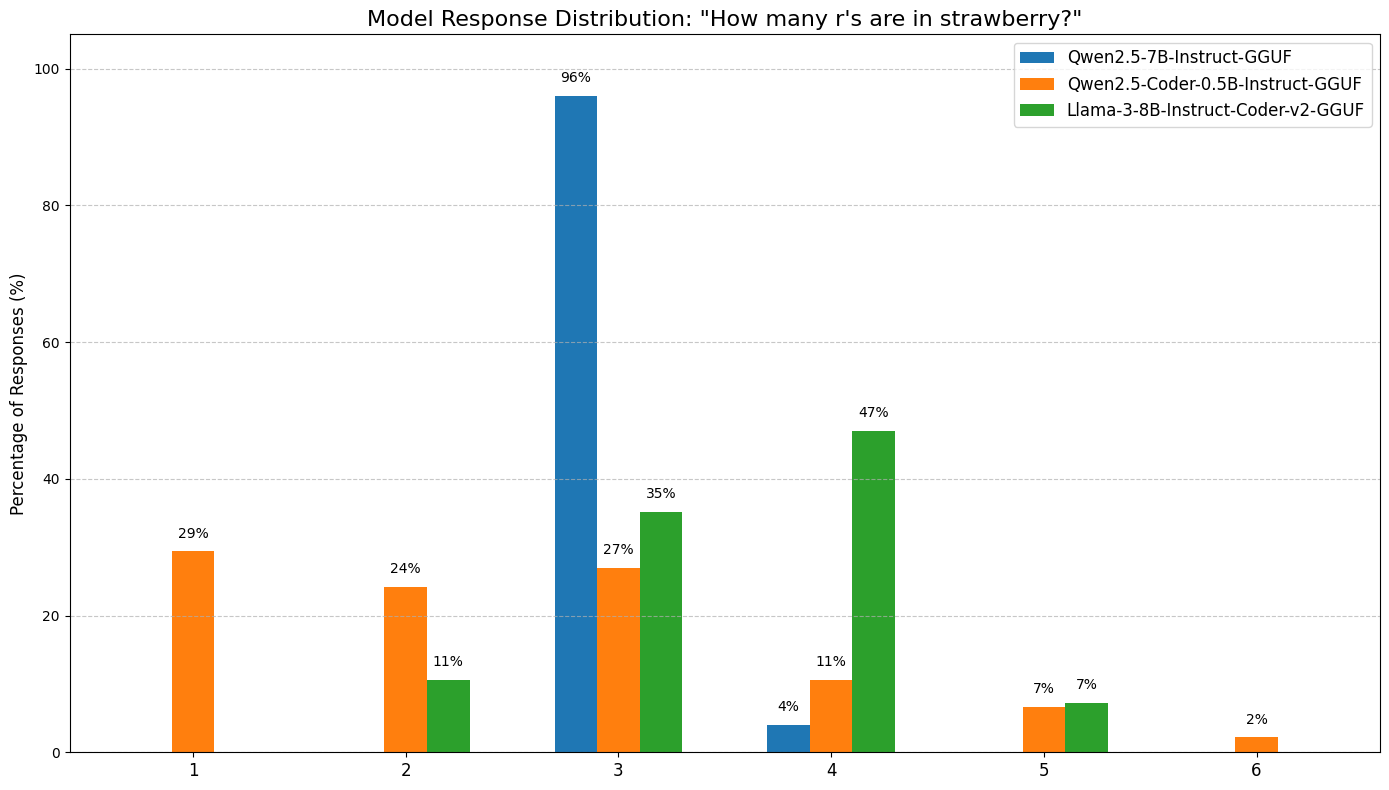

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json

# Get all result files
result_files = [f for f in os.listdir("eval_results") if f.endswith(".json") and f != "all_models_summary.json"]

# Prepare data for visualization
model_names = []
response_distributions = []

for file in result_files:
    model_name = file.split('_')[0]
    model_names.append(model_name)
    
    with open(f"eval_results/{file}", "r") as f:
        data = json.load(f)
    
    # Get response distribution
    responses = {}
    for item in data:
        response = item["response"]
        if response not in responses:
            responses[response] = 0
        responses[response] += 1
    response_distributions.append(responses)

# Plot response distributions
plt.figure(figsize=(14, 8))
width = 0.2
all_responses = sorted(set(resp for dist in response_distributions for resp in dist.keys()))
x = np.arange(len(all_responses))

for i, (model, dist) in enumerate(zip(model_names, response_distributions)):
    values = [dist.get(resp, 0) for resp in all_responses]
    percentages = [v / sum(values) * 100 for v in values]
    plt.bar(x + (i - len(model_names)/2 + 0.5) * width, percentages, width, label=model)

plt.ylabel('Percentage of Responses (%)', fontsize=12)
plt.title('Model Response Distribution: "How many r\'s are in strawberry?"', fontsize=16)
plt.xticks(x, all_responses, fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0, 105)  # Leave room for percentage labels

# Add percentage labels on top of bars
for i, (model, dist) in enumerate(zip(model_names, response_distributions)):
    values = [dist.get(resp, 0) for resp in all_responses]
    percentages = [v / sum(values) * 100 for v in values]
    for j, pct in enumerate(percentages):
        if pct > 0:  # Only add labels to non-zero bars
            plt.text(
                x[j] + (i - len(model_names)/2 + 0.5) * width, 
                pct + 2, 
                f"{pct:.0f}%", 
                ha='center',
                fontsize=10
            )

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()